In [1]:
import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import itertools
import copy
from cyipopt import minimize_ipopt
import warnings
import matplotlib.pyplot as plt
from jax.config import config
# Enable 64 bit floating point precision
config.update("jax_enable_x64", True)

# We use the CPU instead of GPU und mute all warnings if no GPU/TPU is found.
config.update('jax_platform_name', 'cpu')

# import jax.numpy as np
from jax import jit, grad, jacfwd, jacrev
from tqdm.contrib.telegram import tqdm, trange
from dotenv import load_dotenv
import os

from bob_telegram_tools.bot import TelegramBot
load_dotenv()
import pyreadr
import numpy as np
import pickle
import pandas as pd
import statsmodels.api as sm
ranepa_colors = [(146/250,26/250,29/250)
,(230/250 , 43/250, 37/250)
,(231/250, 142/250, 36/250)
,(249/250, 155/250, 28/250)
, (242/250, 103/250, 36/250)]

In [2]:
from olg import *
olg = OLG_model()

In [3]:
olg.steady_state()

[6.08858383 6.16954647 6.24762949 6.32272828 6.39473606 6.46354384
 6.52904031 6.59111191 6.64964269 6.70451434 6.75560612 6.80279482
 6.84595473 6.88495757 6.9196725  6.94996601 6.97570195 6.99674141
 7.01294272 7.02416141 7.03025013 7.03105864 7.02643372 7.01621916
 7.00025569 6.97838093 6.95042935 6.9162322  6.87561749 6.82840989
 6.77443073 6.71349788 6.64542576 6.57002526 6.48710364 6.39646455
 6.29790791 6.19122986 6.07622274 5.95267496 5.82037101 5.67909134
 5.52861231 5.36870616 5.1991409  5.01968024 4.83008357 4.63010584
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
-0.6
[1.50743625 1.50343026 1.49964564 1.49607638 1.49271716 1.48956328
 1.48661069 1.48385591 1.48129602 1.4789287  1.47675216 1.47476515
 1.47296701 1.47135758 1.46993732 1.46870723 1.46766892 1.46682463
 1.46617726 1.46573038 1.46548832 1.46545621 1.46564001 1.46604663
 1.46668401 1.46756119 1.46868848 1.47007756 1.47174166 1.473695

/home/mikhail/science/olg/olg.py:414: RuntimeWarning: divide by zero encountered in power
  print((1 + self.phi * (1/self.phi * 1/ ((1 + self.tau_VA[t_0:(g + 1)]) * (self.price[t_0:(g + 1)]))*
/home/mikhail/science/olg/olg.py:441: RuntimeWarning: divide by zero encountered in power
  (1 + self.phi * (1/self.phi * 1/ ((1 + self.tau_VA[t_0:(g + 1)]) * (self.price[t_0:(g + 1)]))*
/home/mikhail/science/olg/olg.py:443: RuntimeWarning: divide by zero encountered in power
  (1 + self.phi * (1 / self.phi * 1 / ((1 + self.tau_VA[t_0]) * (
/home/mikhail/science/olg/olg.py:441: RuntimeWarning: invalid value encountered in true_divide
  (1 + self.phi * (1/self.phi * 1/ ((1 + self.tau_VA[t_0:(g + 1)]) * (self.price[t_0:(g + 1)]))*



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



NameError: name 'nan' is not defined

In [3]:
# without migrants
non_migration = {name:np.array(pyreadr.read_r(f"{name}_non_migration.Rda")[f"{name}_nm"]) 
                 for name in ["N_female", "N_male"]}
demography_in_model = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
 for t,row in enumerate(non_migration['N_female'])])
Pi = (demography_in_model/demography_in_model.max(axis=0))
Pi_female = Pi[:,(96-65):-20].transpose()
demography_in_model = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
 for t,row in enumerate(non_migration['N_male'])])
Pi = (demography_in_model/demography_in_model.max(axis=0))
Pi_male = Pi[:,(96-65):-20].transpose()
Pi = np.array([Pi_female, Pi_male])
with_migration = {name:np.array(pyreadr.read_r(f"{name}.Rda")[f"{name}"]) 
                 for name in ["N_female", "N_male"]}
N_female = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
 for t,row in enumerate(with_migration['N_female'])])[:,(96-65):-20].transpose()
N_male = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
 for t,row in enumerate(with_migration['N_male'])])[:,(96-65):-20].transpose()
N = np.array([N_female, N_male])


/tmp/ipykernel_66382/3326181543.py:6: RuntimeWarning: invalid value encountered in true_divide
  Pi = (demography_in_model/demography_in_model.max(axis=0))
/tmp/ipykernel_66382/3326181543.py:10: RuntimeWarning: invalid value encountered in true_divide
  Pi = (demography_in_model/demography_in_model.max(axis=0))


In [6]:
# # fertility mortality
# demography_rates = {name:np.array(pyreadr.read_r(f"{name}.Rda")[f"{name}_nm"]) 
#                  for name in ["Fertility", "Mortality_female", "Mortality_male"]}

In [7]:
demography_in_model = np.array([[val if (111-g+t <=111) and (111-g+t>0) else 0 for g, val in enumerate(row)]
 for t,row in enumerate(non_migration['N_female'])])
x = (demography_in_model/demography_in_model.max(axis=0))
health_female = x[:,(96-65):-20].transpose()
health_female = np.array([[0 if (80-g+t >=66+3*min(t/100,1)) else 1 for t, val in enumerate(row)]
 for g, row in enumerate(health_female)])

demography_in_model = np.array([[val if (111-g+t <=111) and (111-g+t>0) else 0 for g, val in enumerate(row)]
 for t,row in enumerate(non_migration['N_male'])])
x = (demography_in_model/demography_in_model.max(axis=0))
health_male = x[:,(96-65):-20].transpose()
health_male = np.array([[0 if (80-g+t >=64+3*min(t/100,1)) else 1 for t, val in enumerate(row)]
 for g, row in enumerate(health_male)])

In [8]:
df_wage = pd.read_excel("rosstat/wage_by_cohort.xlsx")
df_wage_ext = pd.DataFrame([(1,(i-21),(i-21)**2,df_wage['wage'][df_wage['age']<=i].iloc[-1])
                            for i in range(25,70)], columns = ['intercept','age','agesq','wage'])
df_wage_ext['wage']=df_wage_ext['wage']/max(df_wage_ext['wage'])
model = sm.OLS(df_wage_ext['wage'][:40], df_wage_ext[['intercept','age','agesq']][:40]).fit()
params = model.params

In [21]:
epsilon_female =np.array([[-0.0003*(n_generations-g+t)**2+
                                                params[1]*(n_generations-g+t)+
                                               params[0]\
                                         if ((n_generations-g+t) > 0 and (n_generations-g+t)<=n_generations) \
                                         else 0  for t in range(N_female.shape[1]) ] \
                                        for g in range(N_female.shape[0])])
epsilon_male= np.array([[-0.0003*(n_generations-g+t)**2+
                                                params[1]*(n_generations-g+t)+
                                               params[0]\
                                         if ((n_generations-g+t) > 0 and (n_generations-g+t)<=n_generations) \
                                         else 0  for t in range(N_female.shape[1]) ] \
                                        for g in range(N_female.shape[0])])
epsilon_female *= health_female
epsilon_male *= health_male

In [24]:
n_generations=60
epsilon_female =np.array([[-0.0003*(n_generations-g+t)**2+
                                                params[1]*(n_generations-g+t)+
                                               params[0]\
                                         if ((n_generations-g+t) > 0 and (n_generations-g+t)<=n_generations) \
                                         else 0  for t in range(N_female.shape[1]) ] \
                                        for g in range(N_female.shape[0])])
epsilon_male= np.array([[-0.00042*(n_generations-g+t)**2+
                                                params[1]*(n_generations-g+t)+
                                               params[0]\
                                         if ((n_generations-g+t) > 0 and (n_generations-g+t)<=n_generations) \
                                         else 0  for t in range(N_female.shape[1]) ] \
                                        for g in range(N_female.shape[0])])

# epsilon_female = epsilon_male= np.array([[epsilon_female[60][20] if ((n_generations-g+t) > 0 
#                                                                       and (n_generations-g+t)<=20) \
#                                          else  val for t, val in enumerate(row) ] \
#                                         for g, row in enumerate(epsilon_female)])
epsilon_female *= health_female
epsilon_male *= health_male
epsilon = np.array([epsilon_female, epsilon_male])

rho_female = np.array([[1 if ((n_generations-g+t) >= 30 and (n_generations-g+t)<=n_generations) else 0
                        for t in range(N_female.shape[1]) ] 
                       for g in range(N_female.shape[0])])
rho_male = np.array([[1 if ((n_generations-g+t) >= 35 and (n_generations-g+t)<=n_generations) else 0
                      for t in range(N_female.shape[1]) ] 
                     for g in range(N_female.shape[0])])

rho = np.array([rho_female, rho_male])
rho_female_reform = pd.read_csv("rho_female.csv", sep=',',header=None).to_numpy()
rho_male_reform = pd.read_csv("rho_male.csv", sep=',',header=None).to_numpy()

rho_female_reform = rho_female_reform[:669,:610]
rho_male_reform =rho_male_reform[:669,:610]
rho_reform = np.array([rho_female_reform, rho_male_reform])

rho_female_reform_delayed = pd.read_csv("rho_female_reform_delayed.csv", sep=',',header=None).to_numpy()
rho_male_reform_delayed = pd.read_csv("rho_male_reform_delayed.csv", sep=',',header=None).to_numpy()
rho_female_reform_delayed = rho_female_reform_delayed[:669,:610]
rho_male_reform_delayed =rho_male_reform_delayed[:669,:610]
rho_reform_delayed = np.array([np.array(rho_female_reform_delayed), np.array(rho_male_reform_delayed)]) 

rho_f_private = pd.read_csv("rho_female_private.csv", sep=',',header=None).to_numpy()
rho_m_private = pd.read_csv("rho_male_private.csv", sep=',',header=None).to_numpy()
rho_private = np.array([rho_f_private, rho_m_private]) 
rho[0,:609,:609]=rho[0,:609,:609]*np.tri(N=609,k=0)
rho[1,:609,:609]=rho[1,:609,:609]*np.tri(N=609,k=0)
rho_private[0,:609,:609]=rho_private[0,:609,:609]*np.tri(N=609,k=0)
rho_private[1,:609,:609]=rho_private[1,:609,:609]*np.tri(N=609,k=0)
rho_reform[0,:609,:609]=rho_reform[0,:609,:609]*np.tri(N=609,k=0)
rho_reform[1,:609,:609]=rho_reform[1,:609,:609]*np.tri(N=609,k=0)
rho_reform_delayed[0,:609,:609]=rho_reform_delayed[0,:609,:609]*np.tri(N=609,k=0)
rho_reform_delayed[1,:609,:609]=rho_reform_delayed[1,:609,:609]*np.tri(N=609,k=0)
demography = {"N":N, "Pi":Pi, "epsilon":epsilon,"rho":rho,"rho_reform":rho_reform,\
              "rho_reform_delayed":rho_reform_delayed, "rho_private":rho_private}
epsilon_coef = np.sum(demography["N"][:,:,0])/np.sum(demography["N"][:,:,0]*demography["epsilon"][:,:,0])
demography["epsilon"]*=epsilon_coef
np.save('demography.npy', demography)

In [25]:
# plt.scatter(range(21,71),np.exp(df_wage_ext['wage'][:50]), color = ranepa_colors[0], label = "Средняя з/п, 2015 г.")
# plt.plot(range(21,80),epsilon_female[59,:59], color = ranepa_colors[0],label=r"$\epsilon$", linestyle="dashed")
# plt.xlabel('Возраст')
# plt.legend()
# plt.savefig('plots/epsilon.pdf')

In [26]:
# # rho_female_reform = np.array([[1 if ((n_generations-g+t) >= 40 and (n_generations-g+t)<=n_generations) else 0
#                         for t in range(N_female.shape[1]) ] 
#                        for g in range(N_female.shape[0])])
# # rho_male_reform = np.array([[1 if ((n_generations-g+t) >= 45 and (n_generations-g+t)<=n_generations) else 0
#                       for t in range(N_female.shape[1]) ] 
#                      for g in range(N_female.shape[0])])
# import pandas as pd
# # pd.DataFrame(rho_female_reform).to_csv("rho_female.csv", header=False, index=False)
# import pandas as pd
# # pd.DataFrame(rho_male_reform).to_csv("rho_male.csv", header=False, index=False)

In [29]:
mortality = np.array([1-sum(non_migration["N_female"][t,t:(t+109)]+non_migration["N_male"][t,t:(t+109)])\
 /(sum(non_migration["N_female"][t-1,(t-1):(t+109)]) +sum(non_migration["N_male"][t-1,(t-1):(t+109)]))
 for t in range(1,non_migration["N_female"].shape[0])
])
birth = np.array([(row_f[t+110]+row_m[t+110])/(sum(row_f)+sum(row_m)) 
          for t, (row_f, row_m) in enumerate(zip(non_migration["N_female"],
                                                 non_migration["N_male"]))])
total = (with_migration["N_female"]+with_migration["N_female"]).sum(axis=1)[1:]/\
(with_migration["N_female"]+with_migration["N_female"]).sum(axis=1)[:-1]-1
migration = total - birth[1:] + mortality

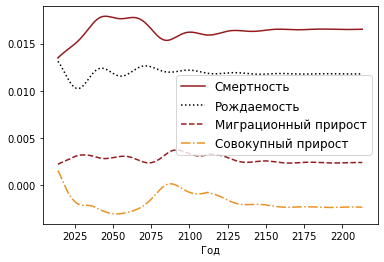

In [30]:
plt.plot(range(2014,2214),mortality[:200], color = ranepa_colors[0], label = "Смертность")
plt.plot(range(2014,2214),birth[1:201], color= "black", linestyle="dotted", label = "Рождаемость")
plt.plot(range(2014,2214),migration[:200], color = ranepa_colors[0], linestyle="dashed", label = "Миграционный прирост")
plt.plot(range(2014,2214),total[1:201], color = ranepa_colors[2], linestyle = "dashdot", label = "Совокупный прирост")
plt.xlabel("Год")
plt.legend()
plt.savefig('plots/demography_rates.pdf')

Начинаем расчет сценариев

Находим момент 100, и повышаем налог на потребление в течение 10 лет на столько %, сколько дефицит составляет в году 100/ доля потребления в ВВП

In [3]:
from olg import *

In [59]:
import pickle
name = "private" # +88 +106
# name = "reform" # +69 + 89
# name = "reform_delayed" # +33 - 100 - 119 закончили!
# name = "baseline" # +16 +90
with open(f'result/{name}_after_tax.file', 'rb') as f:
    olg = pickle.load(f)

In [60]:
olg.Debt[0]=120.
for t in range(1,600):
    olg.update_government(t,2)

In [61]:
((olg.Rho_Outcome-olg.Rho_sum+olg.Rho_lamp_sum)/olg.GDP)[4]

0.0364561205329186

In [62]:
((olg.Gov-olg.Rho_lamp_sum)/olg.GDP)[4]

0.27322402620345687

In [63]:
olg.Deficit_ratio[4]

0.07423729991046

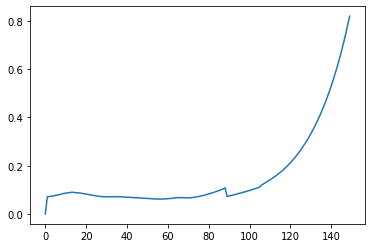

In [65]:
plt.plot(olg.Deficit_ratio[:150])
# plt.plot(olg.Debt[1:150]/olg.GDP[1:150])

In [66]:
olg.GDP[98]

386.26086078036826

In [67]:
where_adjust = np.where(abs(olg.Deficit_ratio)>0.1)[0][1]

In [68]:
import numpy as np
import matplotlib.pyplot as plt

In [69]:
where_adjust

87

In [70]:
tax_adj = olg.Deficit_ratio[where_adjust]/(olg.price[where_adjust]*\
                                           (olg.Consumption[where_adjust]+olg.I[0,where_adjust]+olg.I[1, where_adjust])/\
                                           olg.GDP[where_adjust])
print(tax_adj)

0.17154193192399306


In [71]:
olg.tau_VA[where_adjust+1:] = olg.tau_VA[where_adjust]+tax_adj

In [72]:
with open(f'result/{name}_tax{where_adjust}.file', 'wb') as f:
    pickle.dump(olg, f,protocol = pickle.HIGHEST_PROTOCOL)

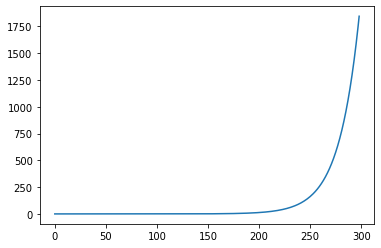

In [553]:
plt.plot(olg.Deficit_ratio[1:300])

In [64]:
olg.GDP[250]

1260.4636287269466

In [11]:
olg.Debt[0]

162.47627078436173

In [78]:
44.089**0.35 * 72.508**0.65# * 0.10051

60.92091799485524

In [91]:
olg.Gov[0]/70

0.1740597656995864

In [95]:
44.089**0.35 * 72.508**0.65*0.0914 /(1-0.0914)

6.128298376325961

In [12]:
olg.Deficit[3]

-2.070937752136963

In [79]:
olg.update_government(0)

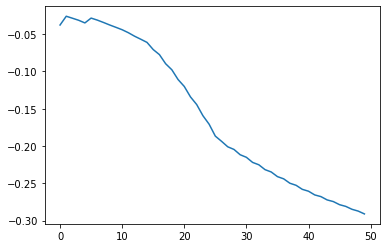

In [16]:
# olg.Oil[:]=6.128298376325961
for i in range(1,500):
    olg.update_government(i,1)
plt.plot(olg.Deficit_ratio[:50])


In [14]:
import matplotlib.pyplot as plt

In [10]:
olg.GDP[1:200]

array([  95.34485953,   94.90311785,   97.03339005,   99.92344622,
        103.88968284,  106.08533335,  108.34350834,  110.77166743,
        113.34330636,  115.94766609,  118.57111593,  121.18378979,
        124.04534584,  127.06761091,  130.11102874,  133.1521361 ,
        136.38517005,  139.76827246,  143.13893807,  146.45317745,
        149.74983625,  152.96765549,  156.10444402,  159.1380718 ,
        162.06260577,  164.8932945 ,  167.66712174,  170.37980462,
        173.08906001,  175.80189376,  178.68067994,  181.74986203,
        184.95985861,  189.21569474,  193.37187731,  198.00481449,
        203.19917202,  208.98602983,  215.4303644 ,  222.53291159,
        230.27003996,  238.69937238,  247.75113914,  257.37732277,
        267.44442129,  277.86790991,  288.61577505,  299.57803158,
        310.62081948,  321.73945971,  332.79431111,  343.79512261,
        354.63979353,  365.32667794,  375.83917745,  386.14396769,
        396.23066646,  405.95292847,  415.27401057,  424.14336

In [128]:
olg.Consumption+olg.Gov+olg.I.sum(axis=0)

array([   67.04921637,    59.46630931,    59.37393937,    60.7125249 ,
          62.34891317,    64.35673144,    65.77772187,    67.17660103,
          68.65751435,    70.21523666,    71.80131057,    73.40584205,
          75.03258074,    76.86307685,    78.83943328,    80.88189896,
          83.02030576,    85.37999752,    87.93897737,    90.61796264,
          93.41000376,    96.34321732,    99.40476247,   102.59357647,
         105.90708011,   109.3501193 ,   112.91257839,   116.60649836,
         120.39344225,   124.23778572,   128.09952554,   131.95407554,
         135.74223459,   139.53204373,   143.30712687,   146.83736637,
         150.27752915,   153.69176465,   157.11457703,   160.59899938,
         164.16342106,   167.84476333,   171.66965578,   175.62855867,
         179.67547537,   183.78182108,   187.90292999,   192.04908223,
         196.14442159,   200.16508516,   204.10698109,   207.94946752,
         211.68794918,   215.32368132,   218.88317865,   222.37036884,
      

In [141]:
self=olg
t=2
self.Oil[t]+(self.price_N[t]*(self.k[0,t]*self.L_share[0,t])**self.alpha+self.price_E[t]*\
 (self.k[1,t]*self.L_share[1,t])**self.alpha)*(self.A[0,t]*self.Labor[t])

75.19852969123318

In [163]:
np.array([7433.8, 5862.7, 4844.0, 5971.9, 9017.8, 7924.3, 5235.2, 9056.5])/7433.8

array([1.        , 0.78865452, 0.65161828, 0.80334418, 1.21308079,
       1.0659824 , 0.70424278, 1.21828674])

In [170]:
(olg.Rho_Outcome-olg.Rho_sum)/olg.GDP

array([0.01786419, 0.01892512, 0.02042488, 0.0208918 , 0.02006908,
       0.01759194, 0.01833017, 0.01927905, 0.02065089, 0.02229004,
       0.02410714, 0.02553172, 0.02641421, 0.02698524, 0.02741808,
       0.02775848, 0.02799916, 0.0281582 , 0.02834243, 0.02856702,
       0.02889957, 0.02914791, 0.02960688, 0.03010735, 0.03050817,
       0.03101541, 0.031209  , 0.03148985, 0.03161245, 0.03175818,
       0.03201034, 0.03193798, 0.03172461, 0.03141811, 0.03034949,
       0.02976805, 0.02881485, 0.02787106, 0.02685965, 0.02570674,
       0.02446391, 0.02301111, 0.02168702, 0.02046213, 0.01913672,
       0.01778277, 0.01640631, 0.01543575, 0.01448112, 0.01348848,
       0.01258833, 0.01182145, 0.01117569, 0.01057478, 0.01014163,
       0.00983488, 0.00958766, 0.00962375, 0.00985588, 0.01030889,
       0.01075137, 0.01121262, 0.01174703, 0.01233359, 0.01283963,
       0.01337656, 0.01382495, 0.01391395, 0.01427762, 0.01459277,
       0.01489978, 0.0152224 , 0.01556507, 0.01578576, 0.01592

array([   6.70130098,    6.34517858,    6.35030469,    6.46827583,
          6.63601803,    6.81827775,    6.95793259,    7.09850712,
          7.24918634,    7.40942166,    7.57077107,    7.73169223,
          7.89012312,    8.06797982,    8.25703114,    8.44677365,
          8.63571007,    8.83798576,    9.05087266,    9.26287839,
          9.47082137,    9.67771185,    9.87952302,   10.07585509,
         10.26526002,   10.44741368,   10.62308255,   10.79586604,
         10.96582282,   11.1374923 ,   11.31177957,   11.49958678,
         11.70326626,   11.91566978,   12.19698521,   12.47881553,
         12.79350934,   13.14712454,   13.54107685,   13.97951014,
         14.46225498,   14.98767539,   15.55946866,   16.1733584 ,
         16.82612427,   17.50979849,   18.21828661,   18.95063752,
         19.69916598,   20.4552573 ,   21.21924881,   21.98176047,
         22.74342602,   23.49744811,   24.24349205,   24.97969792,
         25.70281203,   26.41225659,   27.0971525 ,   27.75412

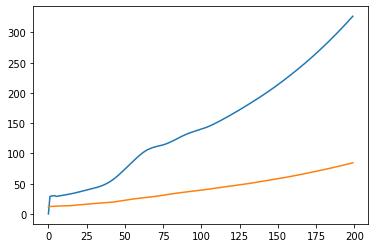

In [57]:
plt.plot(olg.Gov_Income[:200])
plt.plot(olg.Gov[:200])

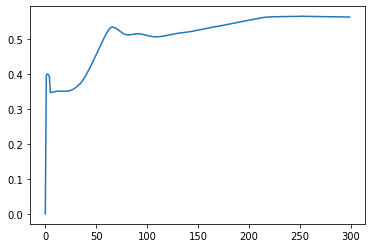

In [61]:
plt.plot(olg.Gov_Income[:300]/olg.Labor[:300]/olg.A[0,:300])

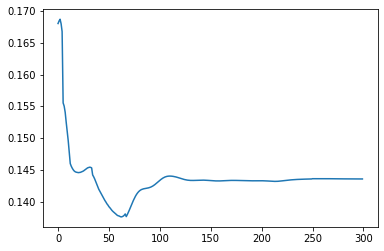

In [62]:
plt.plot(olg.Gov[:300]/olg.Labor[:300]/olg.A[0,:300])

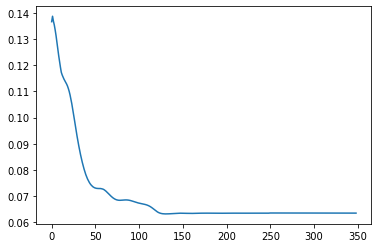

In [51]:

plt.plot(olg.Gov[1:350]/olg.GDP[1:350])

In [4]:
import pickle
with open(f'result/reform.file', 'rb') as f:
    olg = pickle.load(f)


In [9]:
olg.price[1]

0.8984695597199015

In [7]:
plt.plot(olg.Deficit_ratio[:5])

NameError: name 'plt' is not defined

In [20]:
olg.steady

array([2.58146012e+00, 8.09923249e-01, 6.05438110e-01, 1.91234558e+01,
       1.00000000e+00, 1.00000000e+00, 6.59843708e+02, 4.35876523e+01,
       7.80289501e+02])

In [24]:
olg.I[0,:10]

array([4.172004  , 3.54789885, 3.85908733, 4.17595453, 4.45765254,
       4.70911936, 4.94507475, 5.16180836, 5.3715093 , 5.57548254])

In [28]:
olg.price

array([0.25756933, 0.26053906, 0.26350878, 0.2664785 , 0.26944822,
       0.27241795, 0.27538767, 0.27835739, 0.28132712, 0.28429684,
       0.28726656, 0.29023628, 0.29320601, 0.29617573, 0.29914545,
       0.30211517, 0.3050849 , 0.30805462, 0.31102434, 0.31399406,
       0.31696379, 0.31993351, 0.32290323, 0.32587296, 0.32884268,
       0.3318124 , 0.33478212, 0.33775185, 0.34072157, 0.34369129,
       0.34666101, 0.34963074, 0.35260046, 0.35557018, 0.3585399 ,
       0.36150963, 0.36447935, 0.36744907, 0.3704188 , 0.37338852,
       0.37635824, 0.37932796, 0.38229769, 0.38526741, 0.38823713,
       0.39120685, 0.39417658, 0.3971463 , 0.40011602, 0.40308574,
       0.40605547, 0.40902519, 0.41199491, 0.41496464, 0.41793436,
       0.42090408, 0.4238738 , 0.42684353, 0.42981325, 0.43278297,
       0.43575269, 0.43872242, 0.44169214, 0.44466186, 0.44763158,
       0.45060131, 0.45357103, 0.45654075, 0.45951048, 0.4624802 ,
       0.46544992, 0.46841964, 0.47138937, 0.47435909, 0.47732

In [20]:
olg.Gov[250]/olg.A[0,250]/olg.steady[-2]

0.2465664286735258

In [200]:
olg.gov_retirement_strategy = "fixed_tau_rho"

In [7]:
# with open(f'result/reform.file', 'wb') as f:
#     pickle.dump(olg, f,protocol = pickle.HIGHEST_PROTOCOL)

In [201]:
olg.steady_state()

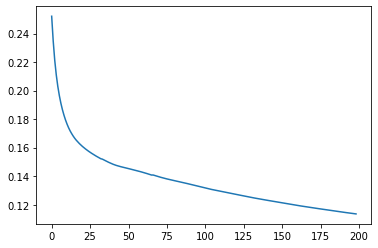

In [26]:
plt.plot(olg.Gov[1:200]/olg.GDP[1:200])

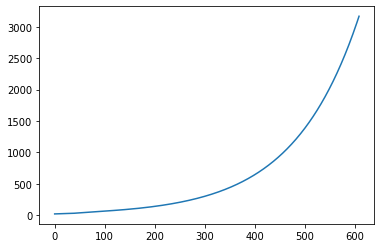

In [10]:
plt.plot(olg.Gov)

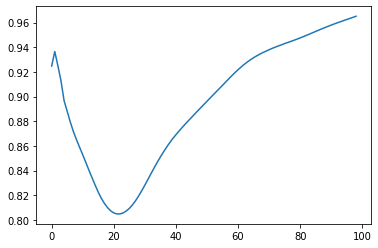

In [6]:
plt.plot(olg.price_N[1:100])

In [7]:
olg.Gov[50]/olg.Labor[50]/olg.A[0,50]

0.14458168803699992

In [24]:
olg.k[0,50]**olg.alpha*

1.8038166206993804

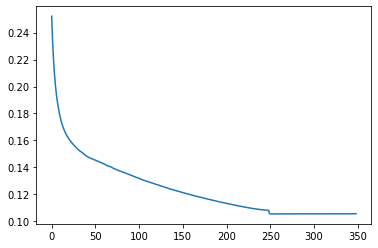

In [88]:
olg.update_government(250)
olg.Gov[250]/olg.GDP[250]

0.06336500868969361

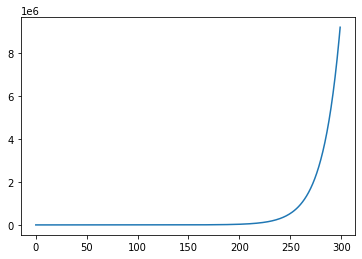

In [84]:
plt.plot(olg.Debt[:300])

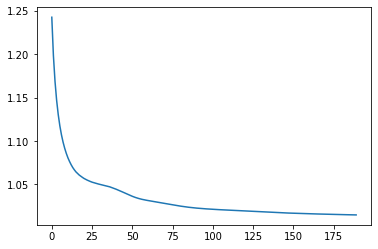

In [23]:
plt.plot(olg.Debt[10:200]/olg.Debt[9:199])

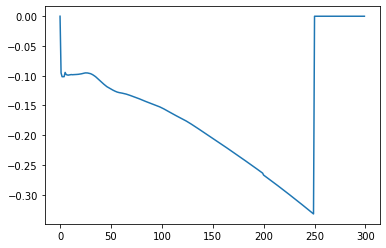

In [24]:
plt.plot(olg.Deficit_ratio[:300])

In [13]:
olg.history[50]

[     fun: 2.192232146792786e-18
     info: {'x': array([0.23473682, 2.89442148, 0.96766975, 1.94528556, 0.18737795,
        0.54020413, 1.28812806, 4.01113349, 1.56480757, 1.84510224]), 'g': array([], dtype=float64), 'obj_val': 2.192232146792786e-18, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
     nfev: 22
      nit: 11
     njev: 13
   status: 0
  success: True
        x: array([0.23473682, 2.89442148, 0.96766975, 1.94528556, 0.18737795,
        0.54020413, 1.28812806, 4.01113349, 1.56480757, 1.84510224]),
      fun: 1.3623460207979244e-17
     info: {'x': array([0.2402

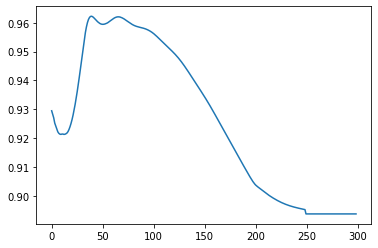

In [198]:
plt.plot(olg.L_share[0,1:300])

In [210]:
for i in range(300):
    olg.update_government(i)

In [211]:
olg.sigma

array([0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356     ,
       0.356     , 0.356     , 0.356     , 0.356     , 0.356  

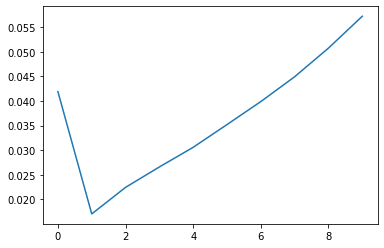

In [182]:
plt.plot(olg.Deficit_ratio[:10])

In [181]:
for i in range(250,300):
    olg.update_guess(i)

In [179]:
for i in range(250,300):
    olg.update_household(i)

In [180]:
olg.eta = 0.5

In [176]:
olg.history[252][-1]

     fun: 2.2101359611231565e-21
    info: {'x': array([ 0.0685037 ,  2.84818664,  0.89418004,  1.19054416,  0.06850254,
        0.33846178,  1.1902101 , 19.53333966,  1.00106044,  1.00145096]), 'g': array([], dtype=float64), 'obj_val': 2.2101359611231565e-21, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 4
     nit: 3
    njev: 5
  status: 0
 success: True
       x: array([ 0.0685037 ,  2.84818664,  0.89418004,  1.19054416,  0.06850254,
        0.33846178,  1.1902101 , 19.53333966,  1.00106044,  1.00145096])

In [90]:
(self.steady[5]*self.steady[0]**self.alpha+self.price_E[self.T]*\
 self.steady[2]**self.alpha)/self.steady[5]*(self.A[0,250]*self.Labor[250])

1778.221290075376

In [97]:
t=250


513.2577800612584

In [5]:
olg.Deficit_ratio[0]

0.010682566979999798

In [10]:
olg.lmbda_to_price_steady

1.2119523375032153

In [30]:
olg.create_guess(t_0=100,steady_start = 200)


KeyboardInterrupt: 

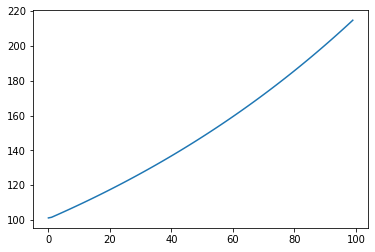

In [77]:
t=247
i_N, k_N, L_N_share, lmbda_N_to_price,\
                i_E, k_E, lmbda_E_to_price,\
                w, price, price_N=olg.i[0,t],olg.k[0,t+1],olg.L_share[0,t],\
            olg.lmbda_to_price[0,t], olg.i[1,t],olg.k[1,t+1],\
            olg.lmbda_to_price[1,t],\
            olg.w[t], olg.price_N[t], olg.price[t]
lag_i = self.i[:,t-1]
lag_K = self.K[:, t-1]
self=olg

In [71]:
price_N*((self.k[0,t]/L_N_share)**self.alpha *L_N_share\
- self.Gov[t]/(self.A[0,t]*self.Labor[t])) - \
(1-self.omega) * price * \
(self.Consumption[t]/(self.A[0,t]*self.Labor[t]) +\
i_N*k_N + i_E*k_E)

0.18606292841321348

In [29]:
self.Gov[t]#/(self.A[0,t]*self.Labor[t])

NameError: name 'self' is not defined

In [28]:
self.gov_ratio[t] * (self.Oil[t]+\
        np.sum(np.array([self.price_N[t], self.price_E[t]])*\
        self.K[:,t]**self.alpha * (self.A[:,t]*self.L[:,t])**(1-self.alpha)/self.price[t]))

NameError: name 'self' is not defined

In [64]:
olg.L_share[0,248:260]

array([0.86031814, 0.81948939, 0.86031814, 0.86031814, 0.86031814,
       0.86031814, 0.86031814, 0.86031814, 0.86031814, 0.86031814,
       0.86031814, 0.86031814])

In [47]:
olg.create_guess(t_0=100,steady_start = 200)

In [8]:
olg.steady

array([2.84788959e+00, 8.93517878e-01, 3.38988079e-01, 1.91234126e+01,
       1.00000000e+00, 1.00000000e+00, 6.49538360e+02, 4.26275932e+01,
       7.86389476e+02])

In [45]:
olg.steady_state()

In [46]:
olg.steady

array([2.66197389e+00, 8.60318143e-01, 4.10547146e-01, 1.88474954e+01,
       1.00000000e+00, 1.00000000e+00, 6.14064848e+02, 4.26275932e+01,
       7.56042769e+02])

In [34]:
olg.k[0]

array([0.48766175, 0.51555045, 0.52489838, 0.54386316, 0.55666423,
       0.57729702, 0.59988475, 0.62436783, 0.65152541, 0.68160454,
       0.71433344, 0.75043108, 0.78978354, 0.8264174 , 0.8637588 ,
       0.90298034, 0.94428828, 0.9854482 , 1.02644715, 1.06842257,
       1.11108941, 1.15328885, 1.19494937, 1.23519189, 1.2734974 ,
       1.30919479, 1.34124887, 1.36897764, 1.39218511, 1.41032383,
       1.42387294, 1.43159457, 1.43468607, 1.43365358, 1.42820018,
       1.41936991, 1.40761522, 1.39337447, 1.37667281, 1.35803313,
       1.33806237, 1.31619401, 1.29312716, 1.26895032, 1.24460392,
       1.21996042, 1.19518075, 1.17028222, 1.1456791 , 1.12097659,
       1.09672954, 1.07262643, 1.04899748, 1.02595561, 1.00348483,
       0.98164082, 0.96049314, 0.94060333, 0.92196766, 0.90444587,
       0.88800075, 0.87312632, 0.85970283, 0.84734346, 0.83616311,
       0.82597592, 0.81658389, 0.80769579, 0.79928983, 0.79119446,
       0.78323387, 0.77517626, 0.76705843, 0.75882159, 0.75038

In [42]:
olg.Debt

array([7.10682555e+00, 8.35785951e+00, 9.94617063e+00, 1.20154390e+01,
       1.46045584e+01, 1.71827586e+01, 2.03544643e+01, 2.41867236e+01,
       2.87876539e+01, 3.42594009e+01, 4.06980606e+01, 4.81345817e+01,
       5.65755522e+01, 6.60694109e+01, 7.66876390e+01, 8.85026416e+01,
       1.01579861e+02, 1.16004417e+02, 1.31877808e+02, 1.49293484e+02,
       1.68358235e+02, 1.89151468e+02, 2.11800932e+02, 2.36411071e+02,
       2.63055209e+02, 2.91848387e+02, 3.22827364e+02, 3.56109745e+02,
       3.91762400e+02, 4.29903144e+02, 4.70669240e+02, 5.14133532e+02,
       5.60403810e+02, 6.09607641e+02, 6.61885925e+02, 7.17412358e+02,
       7.76303974e+02, 8.38778772e+02, 9.05056785e+02, 9.75358233e+02,
       1.04992880e+03, 1.12899400e+03, 1.21288643e+03, 1.30194094e+03,
       1.39645604e+03, 1.49674824e+03, 1.60315501e+03, 1.71614140e+03,
       1.83609428e+03, 1.96340038e+03, 2.09850291e+03, 2.24187895e+03,
       2.39403588e+03, 2.55548255e+03, 2.72679622e+03, 2.90858160e+03,
      

In [218]:
for t in reversed(range(200, olg.T)):
        olg.update_guess(t)

In [179]:
olg.gov_strategy = 'unbalanced'
for t in range(5,olg.T):
    olg.update_government(t, 1)

In [180]:
# на момент времени 3 дефицит должен быть 1.45%, исходя из этого выбираем debt

In [201]:
olg.Debt[0] = 81
for t in range(1,olg.T):
    olg.update_government(t, 1)

In [202]:
olg.Deficit_ratio[3]

0.01485283166032864

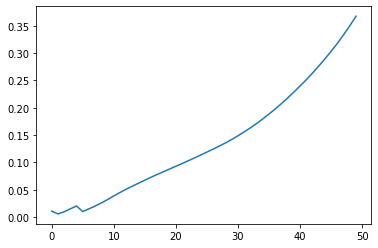

In [203]:
plt.plot(olg.Deficit_ratio[:50])

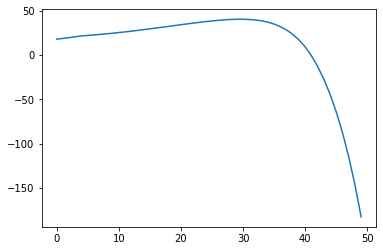

In [141]:
plt.plot(olg.r[:50]*olg.Debt[:50])

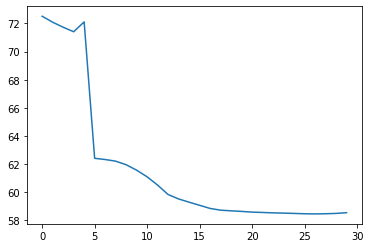

In [61]:
plt.plot(olg.Labor[:30])

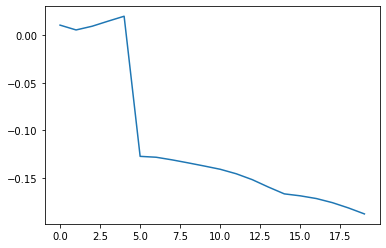

In [45]:
plt.plot(olg.Deficit_ratio[:20])

In [125]:
where_adjust = np.where(abs(olg.Deficit_ratio[10:])>0.05)[0][0]+10
print(where_adjust)

10


-0.186294764045228


In [ ]:
olg

In [87]:
(self.A[0,t]*self.Labor[t])

817.0061683237643

In [129]:
olg.Deficit_ratio[where_adjust+10]

-0.20703069600202842

In [114]:
st = 100
olg.tau_VA[st:(st+50)] = np.linspace(olg.tau_VA[st],olg.tau_VA[st]+tax_adj,50, endpoint=False)
olg.tau_VA[(st+50):] = olg.tau_VA[st]+tax_adj

In [115]:
for i in range(30):
    olg.steady_state()
olg.update_guess(100,200)

In [116]:
with open(f'result/{name}_after_tax.file', 'wb') as f:
    pickle.dump(olg, f,protocol = pickle.HIGHEST_PROTOCOL)

In [119]:
with open(f'result/baseline.file', 'rb') as f:
    olg = pickle.load(f)
with open(f'result/reform.file', 'rb') as f:
    olg_r = pickle.load(f)
with open(f'result/reform_delayed.file', 'rb') as f:
    olg_rd = pickle.load(f)

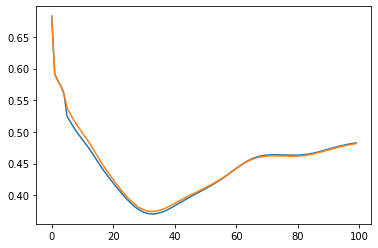

In [126]:
# plt.plot(olg.Consumption[:250]/olg.GDP[:250])
plt.plot(olg_r.Consumption[:100]/olg_r.GDP[:100])
plt.plot(olg_rd.Consumption[:100]/olg_rd.GDP[:100])

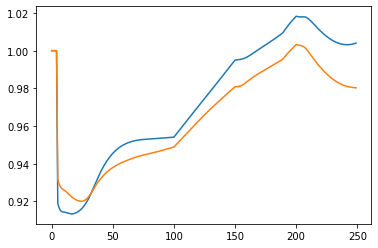

In [135]:
plt.plot(olg_r.Consumption[:250]/olg.Consumption[:250])
plt.plot(olg_rd.Consumption[:250]/olg.Consumption[:250])

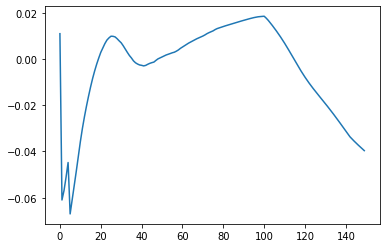

In [144]:
plt.plot(olg.Deficit_ratio[:150])

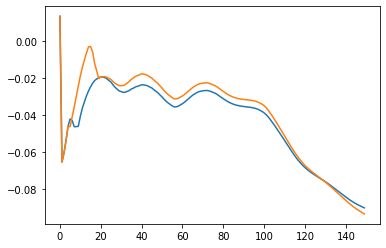

In [145]:
plt.plot(olg_r.Deficit_ratio[:150])
plt.plot(olg_rd.Deficit_ratio[:150])

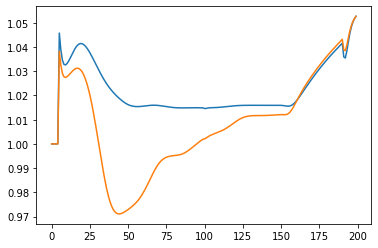

In [131]:
plt.plot(olg_r.K[0,:200]/olg.K[0,:200])
plt.plot(olg_rd.K[0,:200]/olg.K[0,:200])

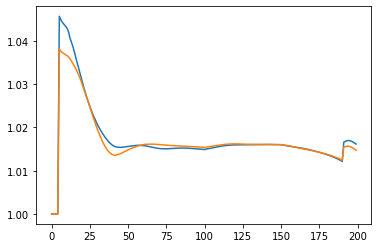

In [133]:
plt.plot(olg_r.Labor[:200]/olg.Labor[:200])
plt.plot(olg_rd.Labor[:200]/olg.Labor[:200])

In [51]:
olg.lmbda[0]

array([0.5       , 2.47827474, 2.41844342, 2.36031941, 2.30484447,
       2.45401368, 2.39182306, 2.33455183, 2.28201374, 2.23351754,
       2.18858896, 2.1471994 , 2.10949188, 2.07490498, 2.04384784,
       2.01634281, 1.99256123, 1.97229792, 1.9552001 , 1.9410438 ,
       1.92969083, 1.92095799, 1.91467187, 1.91060727, 1.90858562,
       1.90840183, 1.90983969, 1.91272863, 1.91680945, 1.92183379,
       1.92760473, 1.93388317, 1.9405152 , 1.94724463, 1.95375973,
       1.95972167, 1.96469108, 1.96825382, 1.97000793, 1.96985827,
       1.96808837, 1.9654454 , 1.96286029, 1.96063483, 1.95835555,
       1.95575201, 1.95349919, 1.95244302, 1.95262408, 1.95388769,
       1.95611602, 1.95873823, 1.96139224, 1.96442501, 1.96789617,
       1.97100628, 1.97342901, 1.9759458 , 1.9791497 , 1.98280906,
       1.98656538, 1.99017784, 1.99301994, 1.99490843, 1.99666071,
       1.99856162, 1.99992621, 2.00085934, 2.0024196 , 2.00505723,
       2.00827894, 2.0124864 , 2.01888687, 2.02741278, 2.03650

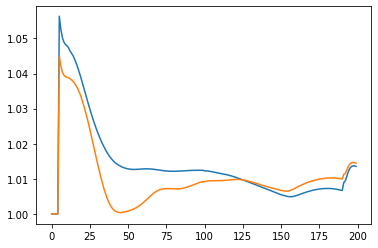

In [134]:
plt.plot(olg_r.GDP[:200]/olg.GDP[:200])
plt.plot(olg_rd.GDP[:200]/olg.GDP[:200])

In [16]:
for i in range(t_0,olg.T):
    olg.update_guess(i)

In [60]:
with open(f'result/reform_delayed.file', 'rb') as f:
    olg_rd = pickle.load(f)
with open(f'result/reform.file', 'rb') as f:
    olg_r = pickle.load(f)

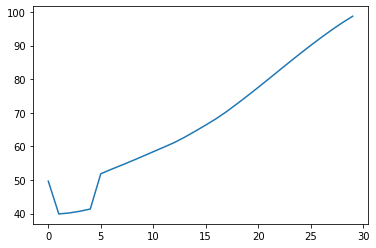

In [24]:
plt.plot(olg.Consumption[:30])
# plt.plot(olg_r.c[0,30,:30])

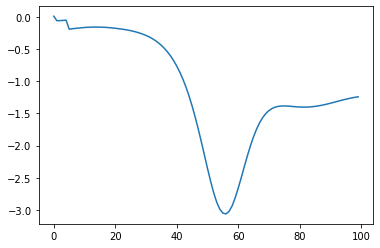

In [25]:
plt.plot(olg.Deficit_ratio[:100])

In [135]:
olg.update_government(2)

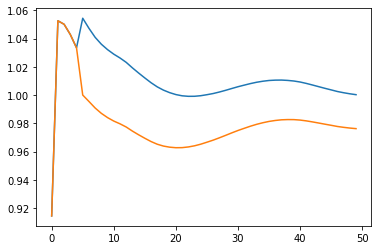

In [39]:
plt.plot(olg.price[:50])
plt.plot(olg_r.price[:50])

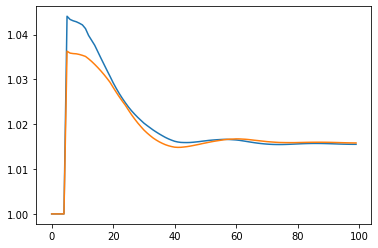

In [64]:
plt.plot(olg_r.Labor[:100]/olg.Labor[:100])
plt.plot(olg_rd.Labor[:100]/olg.Labor[:100])

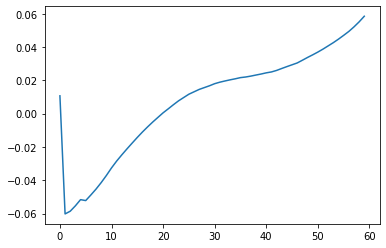

In [115]:
plt.plot(olg.Deficit_ratio[:60])

In [113]:
for i in range(5):
    olg.update_government(i)

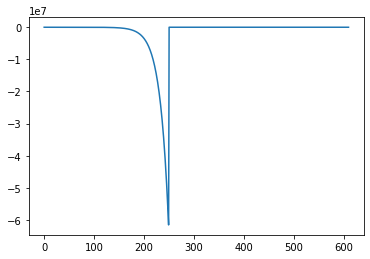

In [123]:
plt.plot(olg_rd.Debt * (1+olg_rd.r))

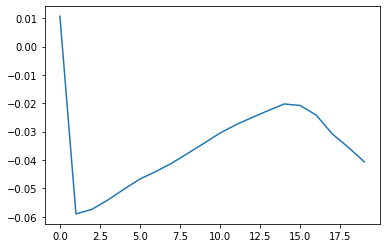

In [114]:
plt.plot(olg_rd.Deficit_ratio[:20])

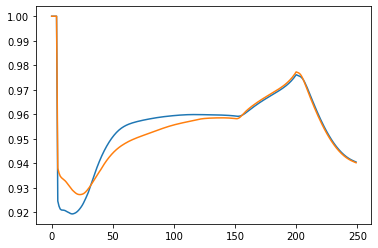

In [75]:
plt.plot(olg_r.Consumption[:250]/olg.Consumption[:250])
plt.plot(olg_rd.Consumption[:250]/olg.Consumption[:250])

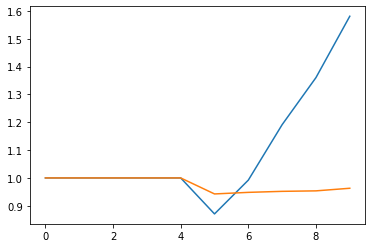

In [94]:
plt.plot(olg_r.Deficit[:10]/olg.Deficit[:10])
plt.plot(olg_rd.Deficit[:10]/olg.Deficit[:10])

In [84]:
)olg.gov_ratio[:]/olg_r.gov_ratio[:]

SyntaxError: unmatched ')' (2506787865.py, line 1)

In [73]:
olg_rd.Consumption[250]/olg.Consumption[250]

0.9530421744273901

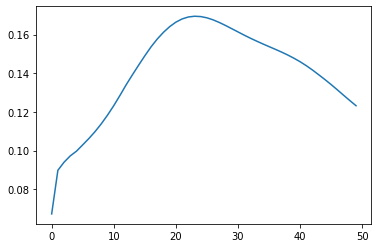

In [3]:
# plt.plot((olg.I[0,:50]+olg.I[1,:50])/(olg.I[0,:50]+olg.I[1,:50]+olg.Consumption[:50]+olg.price_N[:50]/olg.price[:50]*olg.Gov[:50]))

# plt.plot((olg.Consumption[:50])/(olg.Y[1,:50]*olg.price_E[:50]-olg.M[:50]+olg.I[0,:50]+olg.I[1,:50]+olg.Consumption[:50]+olg.price_N[:50]/olg.price[:50]*olg.Gov[:50]))
plt.plot((olg.I[0,:50]+olg.I[1,:50])/(olg.Y[1,:50]*olg.price_E[:50]-olg.M[:50]+olg.I[0,:50]+olg.I[1,:50]+olg.Consumption[:50]+olg.price_N[:50]/olg.price[:50]*olg.Gov[:50]))



In [4]:
olg.gov_strategy

'unbalanced'

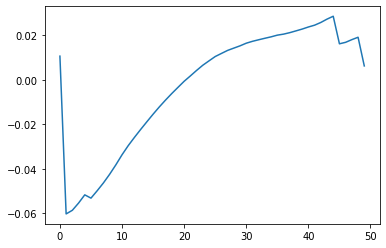

In [412]:
plt.plot(olg.Deficit_ratio[:50])

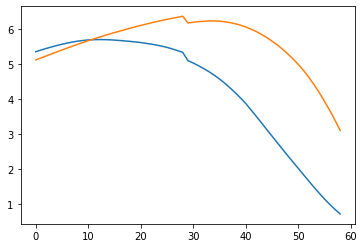

In [399]:
plt.plot(olg.c[1,280,221:280]*olg.Pi[1,280,221:280])
plt.plot(olg.c[0,280,221:280]*olg.Pi[0,280,221:280])

In [356]:
olg.history[245][-1]

     fun: 5.057550761330343e-16
    info: {'x': array([ 0.06961978,  0.39262208,  0.5342929 ,  1.64913584,  0.06982659,
        0.29131528,  1.76591677, 10.28659667,  0.95958656,  0.9451295 ]), 'g': array([], dtype=float64), 'obj_val': 5.057550761330343e-16, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 9
     nit: 8
    njev: 10
  status: 0
 success: True
       x: array([ 0.06961978,  0.39262208,  0.5342929 ,  1.64913584,  0.06982659,
        0.29131528,  1.76591677, 10.28659667,  0.95958656,  0.9451295 ])

In [330]:
for i in range(10):
    olg.steady_state()

In [312]:
olg.update_household(249)

In [132]:
demography["rho_reform"][0,60,25:45]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1.])

In [295]:
olg.steady

array([3.53665828e-01, 5.18803813e-01, 3.28028907e-01, 1.11470004e+01,
       1.00000000e+00, 1.00000000e+00, 3.78937567e+02, 4.26275932e+01,
       4.58775852e+02])

In [296]:
olg.gov_ratio

array([0.28862815, 0.28862815, 0.28862815, 0.28862815, 0.28862815,
       0.28862815, 0.28862815, 0.28862815, 0.28862815, 0.28862815,
       0.28862815, 0.28862815, 0.28862815, 0.28862815, 0.28862815,
       0.28862815, 0.28862815, 0.28862815, 0.28862815, 0.28862815,
       0.28862815, 0.28862815, 0.28862815, 0.28862815, 0.28862815,
       0.28862815, 0.28862815, 0.28862815, 0.28862815, 0.28862815,
       0.28862815, 0.28862815, 0.28862815, 0.28862815, 0.28862815,
       0.28862815, 0.28862815, 0.28862815, 0.28862815, 0.28862815,
       0.28862815, 0.28862815, 0.28862815, 0.28862815, 0.28862815,
       0.26862815, 0.26862815, 0.26862815, 0.26862815, 0.24862815,
       0.24862815, 0.24862815, 0.24862815, 0.22862815, 0.22862815,
       0.22862815, 0.22862815, 0.20862815, 0.20862815, 0.20862815,
       0.18862815, 0.18862815, 0.18862815, 0.16862815, 0.16862815,
       0.16862815, 0.16862815, 0.14862815, 0.14862815, 0.14862815,
       0.14862815, 0.12862815, 0.12862815, 0.12862815, 0.12862

In [294]:
olg.steady_state()

In [228]:
olg.history[191][-1]

     fun: 6.391645578177254e-18
    info: {'x': array([0.07115266, 0.50034691, 0.46953116, 5.36862136, 0.07732016,
       0.16010611, 8.32238054, 4.64436242, 0.72298336, 0.64163649]), 'g': array([], dtype=float64), 'obj_val': 6.391645578177254e-18, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 44
     nit: 20
    njev: 22
  status: 0
 success: True
       x: array([0.07115266, 0.50034691, 0.46953116, 5.36862136, 0.07732016,
       0.16010611, 8.32238054, 4.64436242, 0.72298336, 0.64163649])

In [257]:
olg.eta = 0.4

In [282]:
for i in range(100,200):
    olg.update_guess(i)

In [251]:
olg.w[190:193]

array([5.28103295, 5.29962844, 4.96915127])

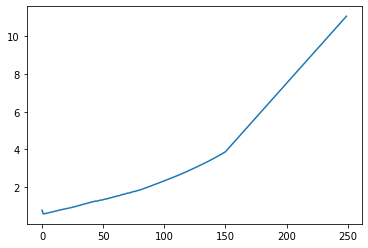

In [273]:
plt.plot(olg.w[:250])

In [278]:
olg.create_guess(110,250)

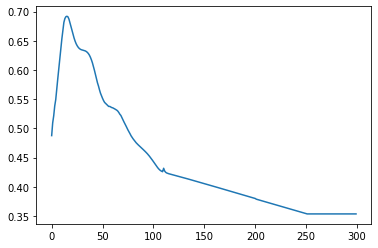

In [283]:
plt.plot(olg.k[0,:300])

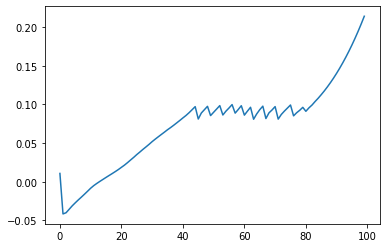

In [265]:
plt.plot(olg.Deficit_ratio[:100])

In [181]:
# olg.Gov_Income
olg.Gov_Outcome[0]

24.714609992525506

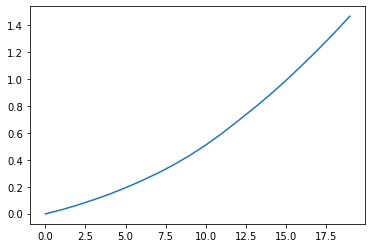

In [189]:
plt.plot(olg.Debt[:20]/olg.GDP[:20])

In [76]:
olg.tau_VA[250]

0.07167761011346026

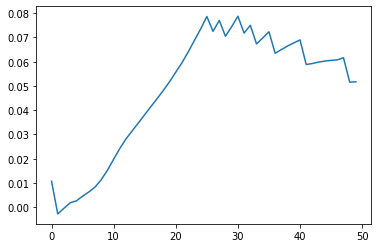

In [155]:
plt.plot(olg.Deficit_ratio[:50])

In [65]:
olg.steady_state()

[0.018427371625713285, -0.08993812441557414, nan, nan, 0.38058548322427443, 2.384759056894836e-13]
[0.018427371625713285, -0.08993812441557414, nan, nan, 0.38058548322427443, 2.384759056894836e-13]


<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars


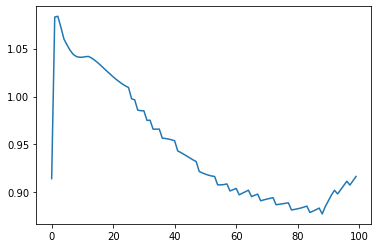

In [167]:
# plt.plot(olg.k[0,:100])
plt.plot(olg.price[:100])
# plt.plot(olg.k[,:100])
# plt.plot(1+olg.Deficit_rati[:100])

In [157]:
olg.k[0]

array([0.48766175, 0.51555045, 0.51326332, 0.53153093, 0.53778918,
       0.5464589 , 0.55048901, 0.55257802, 0.55412115, 0.5555153 ,
       0.55654958, 0.55763431, 0.5584607 , 0.55545224, 0.55183132,
       0.54868248, 0.54613317, 0.54302529, 0.53975162, 0.53717027,
       0.53520375, 0.53347337, 0.53213876, 0.53104024, 0.53018513,
       0.52950821, 0.52969542, 0.52864638, 0.52860205, 0.52745628,
       0.52660609, 0.52631207, 0.52496915, 0.52450177, 0.52278915,
       0.521113  , 0.52004294, 0.51781899, 0.51541969, 0.51287982,
       0.51030122, 0.50807957, 0.5049449 , 0.50195998, 0.49939139,
       0.49712802, 0.49509314, 0.49324393, 0.49226382, 0.49060507,
       0.48930277, 0.4881394 , 0.48719329, 0.48634185, 0.48603252,
       0.48493964, 0.48394414, 0.48311512, 0.48284399, 0.48173994,
       0.48062549, 0.4801074 , 0.47887133, 0.47756964, 0.47620009,
       0.47519839, 0.47342222, 0.47166254, 0.47035919, 0.46839917,
       0.46654109, 0.464755  , 0.46302702, 0.46178843, 0.45998

In [62]:
olg.gov_ratio

array([0.23215308, 0.23215308, 0.23215308, 0.23215308, 0.23215308,
       0.23215308, 0.23215308, 0.23215308, 0.23215308, 0.23215308,
       0.23215308, 0.23215308, 0.23215308, 0.23215308, 0.23215308,
       0.23215308, 0.23215308, 0.23215308, 0.23215308, 0.23215308,
       0.23215308, 0.23215308, 0.23215308, 0.23215308, 0.23215308,
       0.23215308, 0.23215308, 0.23215308, 0.20832736, 0.20832736,
       0.20832736, 0.20832736, 0.20832736, 0.20832736, 0.20832736,
       0.20832736, 0.20832736, 0.20832736, 0.20832736, 0.20832736,
       0.20832736, 0.20832736, 0.20832736, 0.20832736, 0.20832736,
       0.29832778, 0.29832778, 0.29832778, 0.29832778, 0.29832778,
       0.29832778, 0.29832778, 0.29832778, 0.29832778, 0.29832778,
       0.29832778, 0.29832778, 0.29832778, 0.29832778, 0.29832778,
       0.29832778, 0.29832778, 0.29832778, 0.29832778, 0.29832778,
       0.29832778, 0.29832778, 0.29832778, 0.29832778, 0.29832778,
       0.29832778, 0.29832778, 0.29832778, 0.29832778, 0.29832

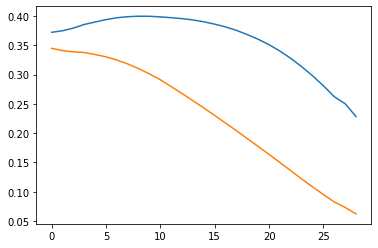

In [61]:
plt.plot(olg.c[0,30,1:30]*olg.Pi[0,30,1:30])
plt.plot(olg.c[1,30,1:30]*olg.Pi[1,30,1:30])

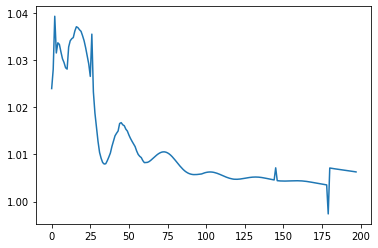

In [40]:
plt.plot(olg.GDP[2:200]/olg.GDP[1:199])

In [30]:
olg.steady_path

[(     fun: 2.7056659446784943e-24
      info: {'x': array([ 0.40059412,  0.58764444,  0.28110061, 11.14700045,  1.        ,
          1.        ]), 'g': array([], dtype=float64), 'obj_val': 2.7056659446784943e-24, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
   message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
      nfev: 16
       nit: 9
      njev: 11
    status: 0
   success: True
         x: array([ 0.40059412,  0.58764444,  0.28110061, 11.14700045,  1.        ,
          1.        ]),
  array([4.15148531e-01, 3.41911111e-01, 1.22775153e-01, 1.02867501e+01,
         1.00000000e+00, 1.00000000e+00, 3.39945772e+02, 4.26275932e+01,
         4.11568883e+0

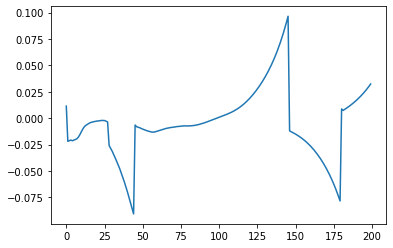

In [22]:
plt.plot(olg.Deficit[:200]/olg.GDP[:200])

In [15]:
olg.steady
for _ in range(10):
    olg.steady_state()

In [16]:
olg.steady

array([4.44521661e-01, 6.52081671e-01, 2.37174112e-01, 1.11470041e+01,
       1.00000000e+00, 1.00000000e+00, 3.78939763e+02, 4.26275932e+01,
       4.58778511e+02])

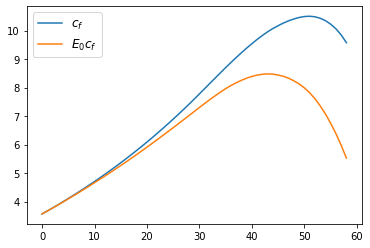

In [184]:
# plt.plot(olg.epsilon[0,250,160:250]*olg.w[160:250]*olg.l[0,250,160:250])
# plt.plot(olg.rho[0,250,160:250]*olg.sigma[160:250]*olg.w[160:250])
# 
plt.plot(olg.c[0,250,191:250], label = "$c_f$")
# plt.plot(olg.c[1,250,191:250], label = "$c_m$")
plt.plot(olg.c[0,250,191:250]*olg.Pi[0,250,191:250], label = "$E_0 c_f$")
# plt.plot(olg.c[1,250,191:250]*olg.Pi[1,250,191:250], label = "$E_0 c_m$")
plt.legend()

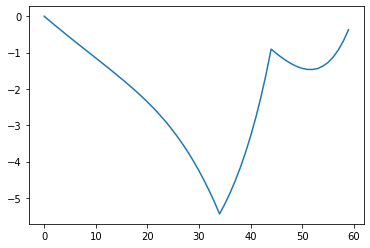

In [10]:
plt.plot(olg.a[1,60,:60], label = "$a_f$")

In [14]:
olg.a[1][30]

array([ 0.1       , -0.1139186 , -0.33628723, -0.56813879, -0.81032592,
       -0.80831516, -0.78856227, -0.74926483, -0.68860199, -0.60463261,
       -0.49501341, -0.35701422, -0.18599835,  0.02112205,  0.26825366,
        0.15662192,  0.04867469, -0.05448721, -0.15172161, -0.24112792,
       -0.32144839, -0.39065028, -0.44584303, -0.48433926, -0.50243404,
       -0.49742198, -0.46556571, -0.40319595, -0.30683404, -0.17301564,
        0.00175438,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [4]:
for t in range(60):
    olg.update_household(t,t)

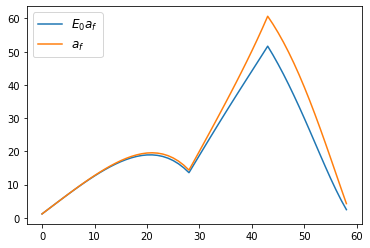

In [203]:
plt.plot(olg.a[0,250,191:250]*olg.Pi[0,250,191:250], label = "$E_0 a_f$")
plt.plot(olg.a[0,250,191:250], label = "$a_f$")
plt.legend()

In [175]:
olg.rho[0,250,(191+39):250]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [159]:
# with open('result/adagov.file', 'rb') as f:
#     olg = pickle.load(f)


# Перезапись модели

In [2]:
# for name in ("baseline", 'sigma_low'):
#     with open(f'copies/olg_{name}.file', 'rb') as f:
#         olg_baseline = pickle.load(f)
#     olg.sigma = olg_baseline.sigma
#     olg.rho = olg_baseline.rho
#     olg.price_N = olg_baseline.price_N
#     olg.K = olg_baseline.K
#     olg.L = olg_baseline.L
#     olg.I = olg_baseline.I
#     olg.gov_const = olg_baseline.gov_const
#     olg.Oil = olg_baseline.Oil
#     olg.gov_ratio = olg_baseline.gov_ratio
#     olg.Deficit= olg_baseline.Deficit
#     olg.Deficit_ratio= olg_baseline.Deficit_ratio
#     olg.GDP = olg_baseline.GDP
#     olg.Gov = olg_baseline.Gov
#     olg.lmbda=olg_baseline.lmbda
#     olg.w=olg_baseline.w
#     olg.price = olg_baseline.price 
#     olg.Y=olg_baseline.Y
#     olg.k=olg_baseline.k
#     olg.i = olg_baseline.i 

#     olg.lmbda_to_price = olg_baseline.lmbda_to_price
#     olg.L_share = olg_baseline.L_share
#     olg.c=olg_baseline.c
#     olg.a=olg_baseline.a
#     olg.l=olg_baseline.l

#     olg.Consumption = olg_baseline.Consumption
#     olg.Labor = olg_baseline.Labor
#     olg.Assets = olg_baseline.Assets
#     olg.steady = olg_baseline.steady
#     olg.steady_path = olg_baseline.steady_path
#     olg.lmbda_to_price_steady =olg_baseline.lmbda_to_price_steady
#     olg.history = olg_baseline.history

#     with open(f'olg_{name}.file', 'wb') as f:
#         pickle.dump(olg, f,protocol = pickle.HIGHEST_PROTOCOL)

# Дефицит

In [105]:
with open(f'olg_baseline.file', 'rb') as f:
    olg_baseline = pickle.load(f)
with open(f'olg_sigma_low.file', 'rb') as f:
    olg_sigma_low = pickle.load(f)
with open(f'olg_baseline_with_reform.file', 'rb') as f:
    olg_reform = pickle.load(f)

In [120]:
olg_reform.Deficit

array([ 7.84035044e-01,  7.59798619e-01,  8.13403360e-01,  8.39221210e-01,
        8.57308388e-01, -8.44950396e-01, -1.35340879e+00, -2.11318986e+00,
       -2.72244256e+00, -3.38339000e+00, -3.68054504e+00, -4.04297808e+00,
       -4.48842093e+00, -4.99846288e+00, -5.57534617e+00, -6.20449304e+00,
       -6.90212274e+00, -7.66853602e+00, -8.51569694e+00, -9.42085472e+00,
       -1.03810923e+01, -1.14335829e+01, -1.25631583e+01, -1.37768498e+01,
       -1.50799365e+01, -1.64397908e+01, -1.79415272e+01, -1.95218536e+01,
       -2.11722108e+01, -2.29402731e+01, -2.47833674e+01, -2.67796459e+01,
       -2.88975204e+01, -3.11679303e+01, -3.36453232e+01, -3.63193373e+01,
       -3.92831929e+01, -4.25119735e+01, -4.60855039e+01, -4.99719109e+01,
       -5.42048197e+01, -5.88624021e+01, -6.39496269e+01, -6.94778174e+01,
       -7.54756424e+01, -8.19472144e+01, -8.89801701e+01, -9.65423705e+01,
       -1.04688567e+02, -1.13496408e+02, -1.22968304e+02, -1.33196346e+02,
       -1.44163475e+02, -

In [94]:
# сильнее всего страдают 25-35 поколения мужчин и 30-40 женщин включительно
rho_reform[1][:36,10]-rho[1,:36,10]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

Text(0.5, 1.0, 'Дефицит бюджета (% ВВП)')

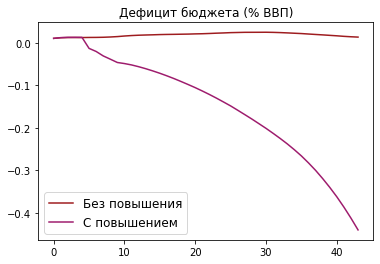

In [112]:
plt.plot(olg_baseline.Deficit_ratio[:44],color = (146/235,26/235,29/235), label = "Без повышения")
plt.plot(olg_reform.Deficit_ratio[:44],color = (146/235,26/235,100/235), label = "C повышением")
# plt.plot(olg_sigma_low.Deficit_ratio[:30],color="black", label = r'$\sigma=0.3$')
plt.legend()
plt.title("Дефицит бюджета (% ВВП)")

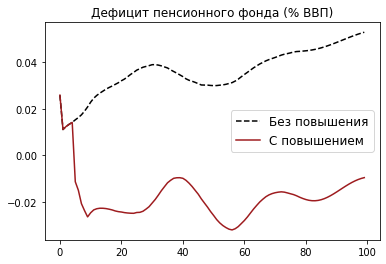

In [273]:
plt.plot(real[0:100],color = "black",linestyle="dashed", label = "Без повышения")
plt.plot(reform[0:100],color = (146/235,26/235,29/235), label = "С повышением")
# plt.plot(((-olg_sigma_low.Rho_sum+
#          (olg_sigma_low.rho*olg_sigma_low.N).sum(axis=(0,1))*olg_sigma_low.sigma *\
#            olg_sigma_low.w)/olg_sigma_low.GDP)[2:100])
plt.legend()
plt.title("Дефицит пенсионного фонда (% ВВП)")
plt.savefig("plots/ret_deficit.pdf")

In [272]:
real[34],reform[34]

(0.038039139214288344, -0.013545308876674076)

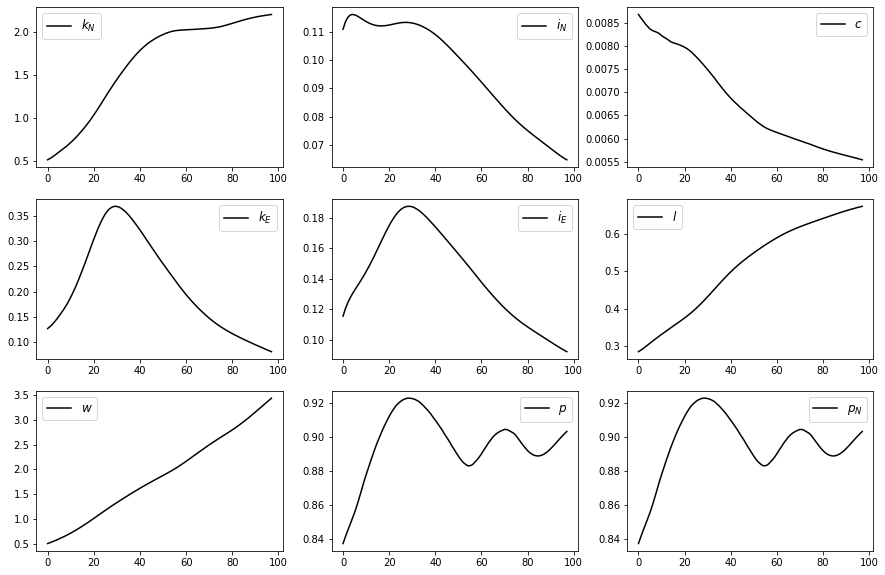

In [158]:
from olg import *
# agg_ref = Aggregate_plot(olg_reform)
agg_baseline = Aggregate_plot(olg_baseline)
# agg_ref.create()
# m = agg_baseline.update()
# m
agg_baseline.create

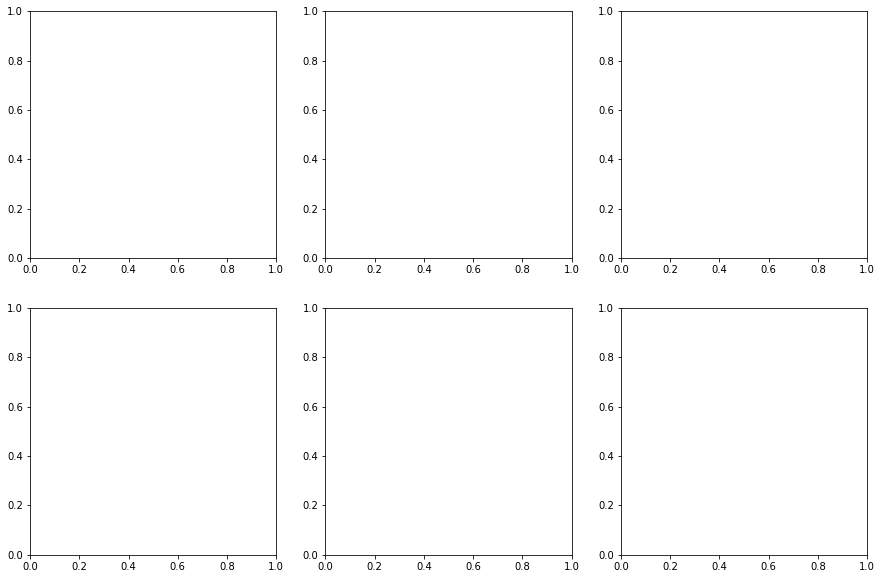

In [222]:
h_baseline = Household_plot(olg_baseline)

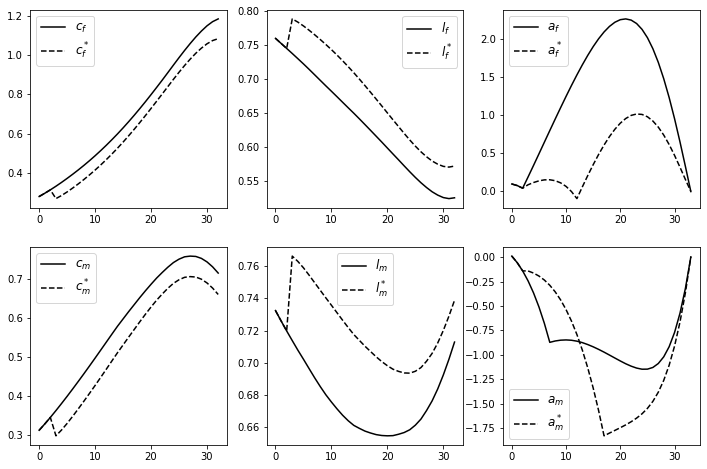

In [281]:
fig, ax =plt.subplots(2,3, figsize=(12,8))
ax[0,0].plot(olg_baseline.c[0,35,2:35], color="black", label = r"$c_f$")
ax[1,0].plot(olg_baseline.c[1,35,2:35],color="black", label = r"$c_m$")
ax[0,1].plot(olg_baseline.l[0,35,2:35], color="black", label = r"$l_f$")
ax[1,1].plot(olg_baseline.l[1,35,2:35], color="black", label=r"$l_m$")
ax[0,2].plot(olg_baseline.a[0,35,2:36], color="black", label=r"$a_f$")
ax[1,2].plot(olg_baseline.a[1,35,2:36], color="black", label=r"$a_m$")

ax[0,0].plot(olg_reform.c[0,35,2:35], color="black", linestyle="dashed", label = r"$c_f^*$")
ax[1,0].plot(olg_reform.c[1,35,2:35], color="black", linestyle="dashed", label = r"$c_m^*$")
ax[0,1].plot(olg_reform.l[0,35,2:35], color="black", linestyle="dashed", label = r"$l_f^*$")
ax[1,1].plot(olg_reform.l[1,35,2:35], color="black", linestyle="dashed", label = r"$l_m^*$")
ax[0,2].plot(olg_reform.a[0,35,2:36], color="black", linestyle="dashed", label = r"$a_f^*$")
ax[1,2].plot(olg_reform.a[1,35,2:36], color="black", linestyle="dashed", label = r"$a_m^*$")
for row in ax:
    for col in row:
        col.legend()
fig.savefig("plots/consumption_res.pdf")

array([0.71773053, 0.71055323, 0.70344769, 0.69641322, 0.68944909,
       0.6825546 , 0.67572905, 0.66897176, 0.66228204, 0.65565922,
       0.64910263, 0.6426116 , 0.63618549, 0.62982363, 0.62352539,
       0.61729014, 0.61111724, 0.60500607, 0.59895601, 0.59296645,
       0.58703678, 0.58116641, 0.57535475, 0.5696012 , 0.56390519,
       0.55826614, 0.55268348, 0.54715664, 0.54168508, 0.53626823,
       0.53090554, 0.52559649, 0.52034052])

In [323]:
g = 35
1-(np.array([olg.beta**(g-2+i) for i in range(g-2)]) *olg.Pi[0,g,2:g]*\
olg_reform.c[0,g,2:g]**(1-olg.phi)*olg_reform.c[0,g,2:g]).sum()/\
(np.array([olg.beta**(g-2+i) for i in range(g-2)]) *olg.Pi[0,g,2:g]*\
olg_baseline.c[0,g,2:g]**(1-olg.phi)*olg_baseline.c[0,g,2:g]).sum()

0.1630286047385242

In [299]:
1-(np.array([olg.beta**(35-2+i) for i in range(33)]) *olg.Pi[1,35,2:35]*\
olg_reform.c[1,35,2:35]**(1-olg.phi)*olg_reform.c[1,35,2:35]).sum()/(np.array([olg.beta**(35-2+i) for i in range(33)]) *olg.Pi[0,35,2:35]*\
olg_baseline.c[1,35,2:35]**(1-olg.phi)*olg_baseline.c[1,35,2:35]).sum()

0.3736745907123262

In [ ]:
        time_0 = range(max(1, olg_reform.g_0-olg_reform.olg.G+1), olg_reform.g_0)
        time_1 = range(max(1, olg_reform.g_1-olg_reform.olg.G+1), olg_reform.g_1)
        olg_reform.ax[0,0].plot(olg_reform.olg.c[0,olg_reform.g_0,time_0], **plt_kwargs,color="red", label = r"$c_{f,0}$")
        olg_reform.ax[0,1].plot(olg_reform.olg.l[0,olg_reform.g_0,time_0], **plt_kwargs,color="red", label = r"$l_{f,0}$")
        olg_reform.ax[0,2].plot(olg_reform.olg.a[0,olg_reform.g_0,range(max(1, olg_reform.g_0-olg_reform.olg.G+1), olg_reform.g_0+1)], **plt_kwargs,color="red", label = r"$a_{f,0}$")
        olg_reform.ax[0,0].plot(olg_reform.olg.c[1,olg_reform.g_0,time_0], **plt_kwargs,color="black", label = r"$c_{m,0}$")
        olg_reform.ax[0,1].plot(olg_reform.olg.l[1,olg_reform.g_0,time_0], **plt_kwargs,color="black", label = r"$l_{m,0}$")
        olg_reform.ax[0,2].plot(olg_reform.olg.a[1,olg_reform.g_0,range(max(1, olg_reform.g_0-olg_reform.olg.G+1), olg_reform.g_0+1)], **plt_kwargs,color="black", label = r"$a_{m,0}$")

In [ ]:
Агрегаты

In [165]:
olg_reform.Labor[250]/olg_baseline.Labor[250]

1.0251770160437923

In [184]:
olg_reform.Consumption[200]/olg_baseline.Consumption[200]

0.9695679157008069

In [167]:
olg_reform.Assets[250]/olg_baseline.Assets[250]

1.0106176438764536

In [185]:
olg_reform.K[:,200].sum()/olg_baseline.K[:,200].sum()

1.0213102643861132

In [186]:
olg_reform.I[:,250].sum()/olg_baseline.K[:,250].sum()

1.0208922265192084

In [191]:
for t in range(500):
    olg_reform.update_government(t)
    olg_baseline.update_government(t)

In [192]:
olg_reform.GDP[300]/olg_baseline.GDP[300]

1.0250680235102148

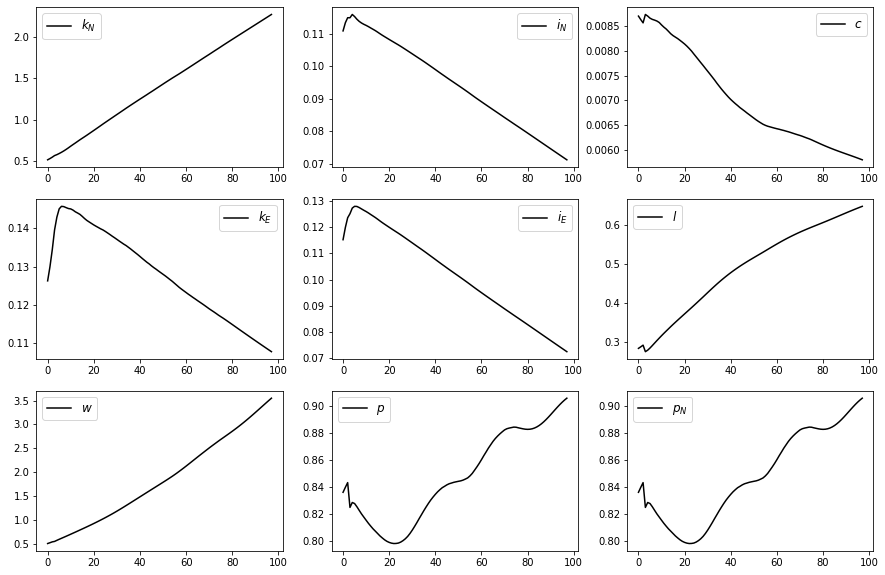

In [159]:
agg_ref = Aggregate_plot(olg_reform)
# agg_ref.create()
# m = agg_baseline.update()
# m
agg_ref.create()

In [157]:
agg_baseline.create()

In [141]:
olg_reform.c[:,:,:5] = olg_baseline.c[:,:,:5]
olg_reform.a[:,:,:5] = olg_baseline.a[:,:,:5]
olg_reform.l[:,:,:5] = olg_baseline.l[:,:,:5]

In [131]:
reform[:5]=real[:5]

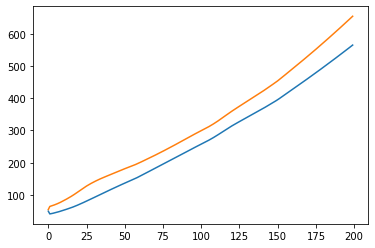

In [78]:
plt.plot((olg_baseline.Consumption+olg_baseline.I.sum(axis=0)+\
          olg.Y[1]*olg.price_E-olg_baseline.M*olg.price_M)[:200])
plt.plot((olg_baseline.Y.sum(axis=0)-olg_baseline.Oil)[:200])

In [63]:
olg_baseline.Y

array([[  48.85857623,   52.20992025,   53.73725542, ..., 3402.77248571,
        3424.85197349, 3447.07472792],
       [  12.06234176,   18.37090382,   18.34667771, ...,  840.08597527,
         845.53702089,  851.02343657]])

array([ 12.06234176,  12.21860825,  12.37609432,  12.534795  ,
        12.69470501,  12.85581875,  13.01813032,  13.18163352,
        13.3463218 ,  13.51218834,  13.67922595,  13.84742715,
        14.01678413,  14.18728874,  14.35893253,  14.53170668,
        14.70560208,  14.88060925,  15.05671841,  15.23391941,
        15.41220179,  15.59155473,  15.77196709,  15.95342737,
        16.13592374,  16.31944402,  16.50397569,  16.68950588,
        16.87602139,  17.06350865,  17.25195377,  17.44134249,
        17.63166023,  17.82289203,  18.01502262,  18.20803635,
        18.40191726,  18.59664901,  18.79221495,  18.98859804,
        19.18578095,  19.38374598,  19.58247507,  19.78194986,
        19.98215163,  20.18306133,  20.38465956,  20.58692659,
        20.78984239,  20.99338655,  21.19753836,  21.40227679,
        21.60758047,  21.81342771,  22.01979652,  22.22666457,
        22.43400923,  22.64180756,  22.85003631,  23.05867193,
        23.26769057,  23.47706807,  23.68678001,  23.89

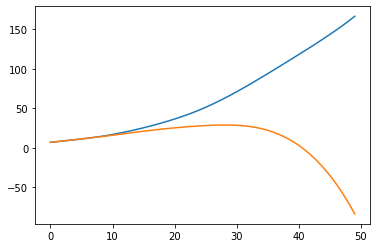

In [28]:
plt.plot(olg_baseline.Debt[:50], label = r'$\sigma=0.356$')
plt.plot(olg_sigma_low.Debt[:50], label = r'$\sigma=0.3$')

In [76]:
olg_baseline.Deficit_ratio[0]

0.019070179062450072

In [75]:
olg_sigma_low.Deficit_ratio
# olg_sigma_low.Gov_Outcome

array([ 1.11761895e-03,  3.48651145e-03,  3.17771491e-03,  2.24107276e-03,
        1.12625387e-03,  2.73419372e-04, -7.88287369e-04, -1.73262278e-03,
       -2.49973701e-03, -3.10322956e-03, -3.45975923e-03, -4.10896495e-03,
       -5.08974211e-03, -6.34103384e-03, -7.75377668e-03, -9.14780071e-03,
       -1.07691002e-02, -1.25240141e-02, -1.42652160e-02, -1.60728847e-02,
       -1.77550359e-02, -1.96017215e-02, -2.13136048e-02, -2.30215080e-02,
       -2.49407149e-02, -2.68646561e-02, -2.92063418e-02, -3.16910348e-02,
       -3.46170607e-02, -3.77404521e-02, -4.10418683e-02, -4.48824156e-02,
       -4.91674931e-02, -5.38540800e-02, -5.89149250e-02, -6.42746310e-02,
       -7.02178097e-02, -7.64601312e-02, -8.30269994e-02, -9.00442171e-02,
       -9.74625431e-02, -1.05465914e-01, -1.13697959e-01, -1.22255361e-01,
       -1.31377158e-01, -1.41125735e-01, -1.51468293e-01, -1.62054410e-01,
       -1.73308646e-01, -1.85372653e-01, -1.98183305e-01, -2.11746942e-01,
       -2.26111985e-01, -

In [44]:
[item[-1]['fun'] for key, item in olg.history.items() if len(item)>0]

[4.413292469055269e-19,
 3.569855203991492e-27,
 1.5765273500182807e-22,
 6.71466342549059e-25,
 4.687850370129405e-19,
 2.5562022021336688e-15,
 2.8259799438914527e-23,
 5.850886913360744e-15,
 3.7031842947429486e-14,
 1.4144832464332535e-20,
 3.716324372982118e-15,
 3.5371983597656044e-19,
 6.556602136041219e-24,
 1.0791170623887522e-24,
 2.077086765143785e-18,
 1.3404368858988483e-15,
 1.4519401613010521e-22,
 9.135477962278117e-18,
 3.3177885736636693e-15,
 2.7838600335810697e-18,
 2.352467256810684e-14,
 5.541997937657359e-20,
 3.882226643282321e-21,
 2.0747435324778435e-20,
 1.343819001795797e-12,
 7.903919167211445e-21,
 8.964460040712521e-17,
 8.972744285489573e-16,
 6.400383140364386e-17,
 4.2305199333580826e-23,
 2.931990065804995e-21,
 3.225802840144607e-19,
 1.4880588207444363e-13,
 3.1555623738614504e-15,
 1.3545227756523034e-16,
 5.863498721514806e-17,
 3.7306876551950795e-17,
 8.548934984013868e-15,
 1.6213223399109558e-12,
 5.103279177328898e-20,
 5.014111026809735e-14,

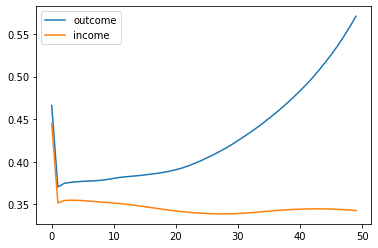

In [29]:
plt.plot(olg.Gov_Outcome[:50]/olg.GDP[:50], label="outcome")
plt.plot(olg.Gov_Income[:50]/olg.GDP[:50], label="income")
plt.legend()

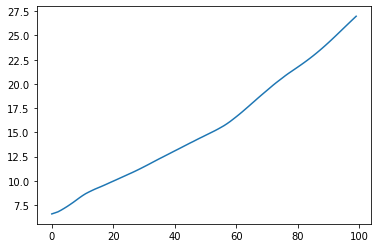

In [35]:
plt.plot((olg.Rho_sum-olg.sigma*olg.w*(olg.rho[:,:,:]*olg.N[:,:,]).sum(axis=(0,1))/olg.GDP)[:100])

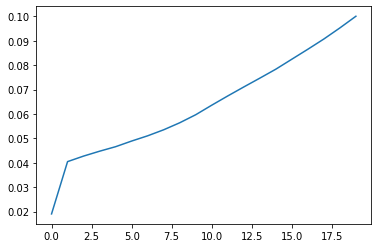

In [13]:
plt.plot(olg.Deficit_ratio[:20])

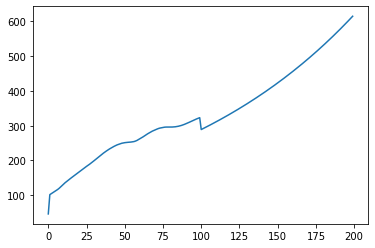

In [345]:
plt.plot(olg.Consumption[:200])#olg.Consumption[:10])

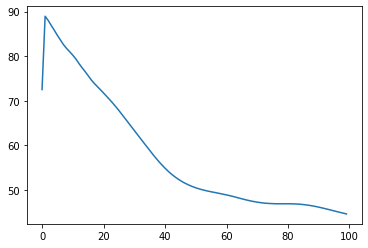

In [346]:
plt.plot(olg.Labor[:100])

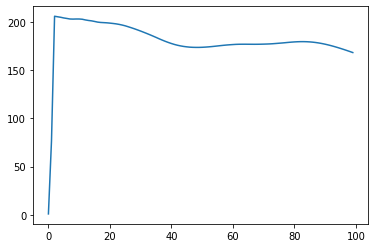

In [347]:
plt.plot(olg.GDP[:100])

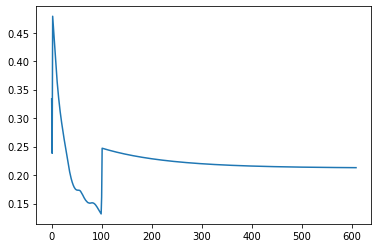

In [343]:
plt.plot(olg.Gov/olg.Consumption)

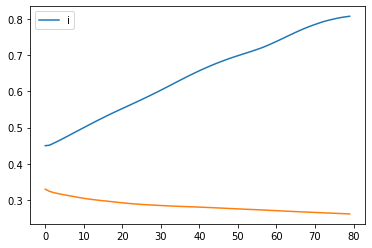

In [315]:
plt.plot(olg.Gov_Income[:80]/olg.GDP[:80], label="i")
plt.plot(olg.Gov[:80]/olg.GDP[:80])
plt.legend()

In [322]:
olg.VA_sum/olg.GDP

array([0.10790161, 0.1078912 , 0.10910434, 0.11059601, 0.1123182 ,
       0.1142798 , 0.11640828, 0.11872756, 0.12119946, 0.12378966,
       0.12645407, 0.12917744, 0.13191688, 0.13463913, 0.13737251,
       0.14012247, 0.14296768, 0.14577562, 0.14854346, 0.1513771 ,
       0.15421618, 0.15712031, 0.16011   , 0.16317295, 0.16631692,
       0.16956322, 0.17287471, 0.17635425, 0.1799782 , 0.18373689,
       0.18763993, 0.19164171, 0.1957737 , 0.20000266, 0.2042722 ,
       0.20856555, 0.21279166, 0.21704455, 0.22123457, 0.22538422,
       0.22944209, 0.23337726, 0.23724428, 0.24102725, 0.24467369,
       0.24822033, 0.25155013, 0.25489913, 0.25808851, 0.26110452,
       0.26412155, 0.26704899, 0.26996163, 0.27288722, 0.27596784,
       0.27922469, 0.28260836, 0.2864471 , 0.29060061, 0.29514293,
       0.29975035, 0.30446978, 0.30932384, 0.31425983, 0.31906345,
       0.32389243, 0.32847144, 0.33298777, 0.33717723, 0.34111337,
       0.34485782, 0.34844466, 0.35188164, 0.35484319, 0.35741

In [128]:
olg.Labor[0]

72.508

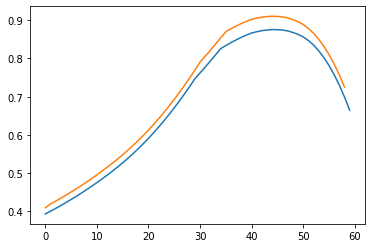

In [297]:
plt.plot(olg.c[:,59::-1,0].sum(axis=0))
plt.plot(olg.c[:,60:1:-1,1].sum(axis=0))

In [291]:
plt.olg.Consumption

array([   36.00754941,    37.49653777,    38.99871907,    40.48347414,
          42.04521184,    43.65901084,    45.38506219,    47.19178569,
          49.19623952,    51.33887349,    53.52311643,    55.69784226,
          57.77472726,    59.8956042 ,    62.08760459,    64.23690638,
          66.44363364,    68.74516546,    71.11602275,    73.55122721,
          75.97208439,    78.44411916,    80.97365531,    83.52122989,
          86.08775272,    88.6946451 ,    91.26999574,    93.97210336,
          96.76789261,    99.64557186,   102.63313456,   105.6740831 ,
         108.81204001,   112.0214195 ,   115.24475634,   118.4837164 ,
         121.62537309,   124.84914184,   128.05332341,   131.29643597,
         134.52684517,   137.72030084,   140.96362595,   144.24920278,
         147.5035767 ,   150.77142256,   153.88619957,   157.15583509,
         160.33153169,   163.37470474,   166.48928297,   169.54609971,
         172.60382365,   175.68072886,   178.9324424 ,   182.36291432,
      

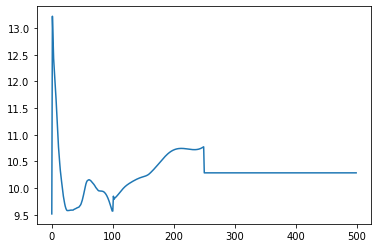

In [110]:
plt.plot(olg.Assets[:500]/olg.Consumption[:500])

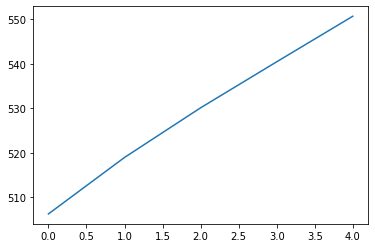

In [111]:
plt.plot(olg.Assets[:5])

In [281]:
olg.Deficit_ratio[0]

0.010261475561036083

In [ ]:
olg.

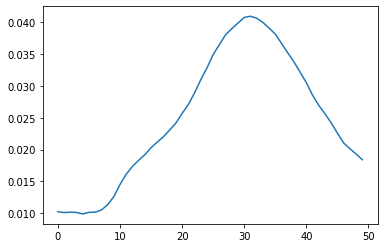

In [290]:
plt.plot(olg.Deficit_ratio[:50])

In [114]:
olg.Gov[0]

20.81693183982865

In [115]:
9.34471688-olg.GDP[0]/10

3.4004001482486554

In [25]:
olg.Gov

array([  20.81693184,   22.61592621,   23.62817006,   23.89868628,
         23.96582485,   24.04572384,   24.18173776,   24.36304636,
         24.61104039,   24.90753774,   25.22163825,   25.53611123,
         25.8263183 ,   26.1272396 ,   26.45296502,   26.77931107,
         27.11737826,   27.48465631,   27.8818203 ,   28.2983752 ,
         28.71993833,   29.15101627,   29.58978963,   30.02820413,
         30.46334871,   30.89577468,   31.31515865,   31.73690144,
         32.15874881,   32.57885862,   33.00065702,   33.41958098,
         33.83948116,   34.25956812,   34.67657042,   35.09282889,
         35.49919621,   35.91494599,   36.33541201,   36.76747877,
         37.20906303,   37.65897035,   38.12538254,   38.60999119,
         39.10665496,   39.61817838,   40.13015646,   40.66501801,
         41.2056679 ,   41.74477793,   42.29482901,   42.84683992,
         43.40048988,   43.95479476,   44.51805096,   45.08934308,
         45.66287029,   46.25639153,   46.86455068,   47.49107

In [12]:
(olg.Gov_Outcome[0]-olg.Gov_Income[0]-6.7)/olg.GDP[0]

-0.13382142957979107

In [13]:
olg.gov_const-6.5

-3.7

In [14]:
olg.Assets[250]/20

469.3266406145593

In [15]:
olg.Gov[0]

20.81693183982865

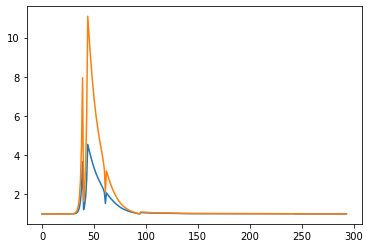

In [119]:
plt.plot(olg.price_N[6:300])
plt.plot(olg.price[6:300])

0.27215541623809786

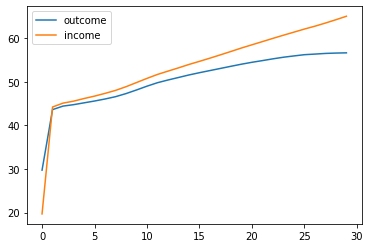

In [17]:
olg.Gov = 0.3195*(olg.Oil+olg.K[:,:].sum(axis=0))**olg.alpha*((olg.A[:,:]*olg.L[:,:]).sum(axis=0))**(1-olg.alpha)
for i in range(500):
    olg.update_government(i)
plt.plot(olg.Gov_Outcome[:30], label="outcome")
plt.plot(olg.Gov_Income[:30], label="income")
plt.legend()
# olg.Deficit[0]/olg.GDP[0]
olg.Debt[0]/olg.GDP[0]

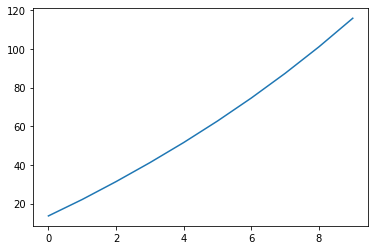

In [46]:
plt.plot(olg.Debt[:10])

In [519]:
(olg.Oil+olg.K[:,:].sum(axis=0))**olg.alpha*((olg.A[:,:]*olg.L[:,:]).sum(axis=0))**(1-olg.alpha)

array([   61.94845964,    67.38175278,    69.56719038,    72.29271419,
          75.01079076,    77.48127518,    79.84176192,    82.11381935,
          84.51980747,    87.04761391,    89.63061034,    92.21889177,
          94.70639263,    97.23071296,    99.79800725,   102.29387178,
         104.79226308,   107.3935942 ,   110.08477033,   112.83079942,
         115.58455932,   118.3728286 ,   121.17843039,   123.96047199,
         126.71034758,   129.43382171,   132.0702932 ,   134.71811615,
         137.35957978,   139.99832241,   142.66528684,   145.33318356,
         148.02778403,   150.74191268,   153.44938738,   156.15850173,
         158.8011524 ,   161.48540861,   164.16167611,   166.87965785,
         169.62631631,   172.39761835,   175.24277036,   178.16695618,
         181.13848604,   184.18411506,   187.20812584,   190.35687074,
         193.5052142 ,   196.62639567,   199.80332007,   202.96463778,
         206.126451  ,   209.2878025 ,   212.51372157,   215.80855773,
      

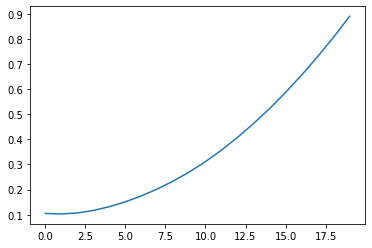

In [549]:
plt.plot((olg.Debt/olg.GDP)[:20])

In [529]:
olg.GDP = olg.Oil+\
        (olg.K[:,:].sum(axis=0))**olg.alpha*((olg.A[:,:]*olg.L[:,:]).sum(axis=0))**(1-olg.alpha)

In [384]:
olg.GDP[:] = (olg.Oil[:]+)

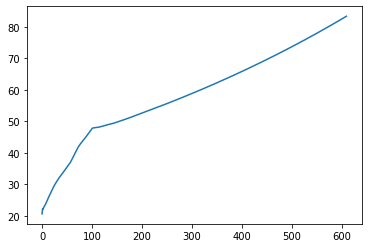

In [397]:
plt.plot(olg.GDP*0.30)

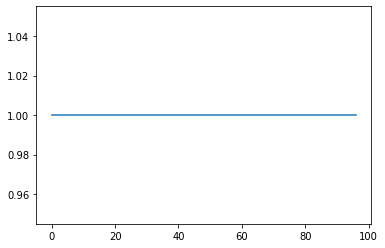

In [559]:
plt.plot(olg.GDP[3:100]/olg.GDP[2:99])

In [377]:
olg.Gov_Outcome[:10]

array([29.84059016, 31.14163894, 31.07363015, 31.06308823, 31.09174767,
       31.12022069, 31.18136445, 31.22319539, 31.37389891, 31.51766399])

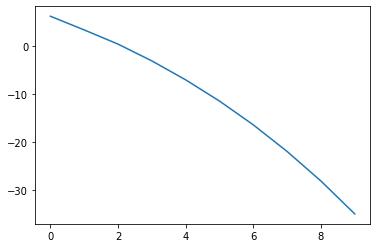

In [379]:
plt.plot(olg.Debt[:10])

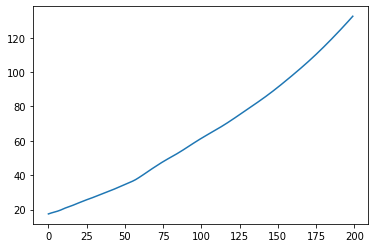

In [342]:
plt.plot(olg.Gov[:200])

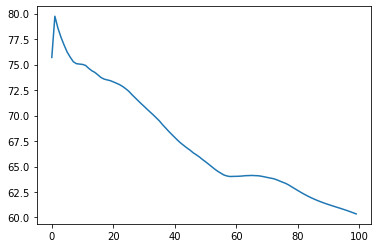

In [341]:
plt.plot(olg.Labor[:100])

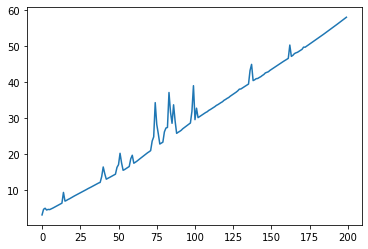

In [86]:
plt.plot(olg.I_sum[:200])

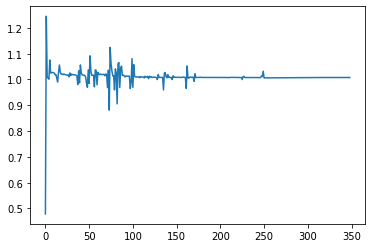

In [119]:
plt.plot(olg.Consumption[1:350]/olg.Consumption[:349])

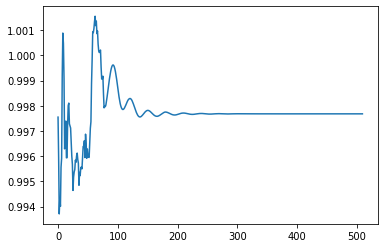

In [48]:
plt.plot(N[:,:,1:511].sum(axis=0).sum(axis=0)/N[:,:,:510].sum(axis=0).sum(axis=0))

In [15]:
Gov_init = olg.Gov_Income[0]-Debt_initial*olg.r[0]-\
np.sum(olg.sigma[0]*olg.rho[:,:,0]*olg.w[0]*olg.N[:,:,0])+GDP_initial*0.01069

In [358]:
Gov_init= 20.929656949411804

In [345]:
olg.Gov[0]=20.882747842555766

In [295]:
olg.Consumption[0]

42.57421319881056

In [296]:
GDP_initial

60.92091799485524

In [204]:
olg.price[0], olg.w[0], olg.

(1.3982259650479656, 0.5461272783231631)

In [195]:
olg.update_household(0)

In [154]:
olg.Consumption[0]

36.50522716560643

In [248]:
olg.K

array([[3.53593780e+01, 3.85165656e+01, 3.76650890e+01, ...,
        2.01876887e+04, 2.03422128e+04, 2.04979197e+04],
       [8.72962200e+00, 9.62803397e+00, 9.85395776e+00, ...,
        1.63777696e+04, 1.65031312e+04, 1.66294523e+04]])

In [202]:
olg.evaluate_initial_state()

In [251]:
olg.K[0,:]/olg.K[1,:]

array([4.05050505, 4.00046009, 3.82233108, 3.81119082, 3.75914166,
       3.69280281, 3.61641406, 3.56946561, 3.5017788 , 3.43144907,
       3.36073865, 3.29179319, 3.22548447, 3.16231808, 3.09856235,
       2.99517262, 2.93587255, 2.89608864, 2.86843707, 2.82957693,
       2.78949912, 2.74957759, 2.71053598, 2.6724295 , 2.63568499,
       2.60029081, 2.56625629, 2.53350883, 2.5020071 , 2.47197857,
       2.44258904, 2.41453798, 2.38745596, 2.36138246, 2.33623679,
       2.31200082, 2.28860211, 2.26595212, 2.24436894, 2.21308345,
       2.1935172 , 2.16700308, 2.15220053, 2.13731528, 2.12206542,
       2.10633836, 2.09046693, 2.07466397, 2.06030365, 2.0365721 ,
       2.0153106 , 2.00113296, 1.98225274, 1.97390133, 1.9652629 ,
       1.95439189, 1.94338818, 1.93192757, 1.91496671, 1.90363848,
       1.89238237, 1.87846397, 1.86861576, 1.86012422, 1.84891193,
       1.83853002, 1.82841579, 1.81796377, 1.80863583, 1.79933752,
       1.7906045 , 1.78165962, 1.77278474, 1.76014675, 1.75206

In [359]:
olg.Gov[0] = Gov_init
for i in range(1,max_time):
    g=A[0,i]/A[0,i-1]
    n=N[:,:,i].sum()/N[:,:,i-1].sum()
    olg.Gov[i] = olg.Gov[0] * n * g 

In [36]:
Gov_init

31.478394489017422

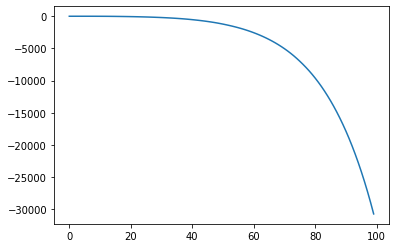

In [212]:
plt.plot(olg.Debt[:100])

In [200]:
Debt_initial

6.1231614676629

In [222]:
olg.Gov_Income[0]/olg.GDP[0]

0.4581979468051867

In [218]:
for i in range(1):
    olg.update_government(i)

In [93]:
olg.c[:,:,0]

array([[0.66855873, 0.76920576, 0.77706917, ..., 0.        , 0.        ,
        0.        ],
       [0.66927592, 0.73535654, 0.74049841, ..., 0.        , 0.        ,
        0.        ]])

In [220]:
olg.GDP

array([53.93029838, 66.37603274, 66.15273711, 65.80769822, 65.49997724,
       65.17534173, 64.93607898, 64.71732971, 64.67438806, 64.72187402,
       64.74755932, 64.69920798, 64.50124724, 64.32522327, 64.18717569,
       63.97229205, 63.75844078, 63.61354703, 63.50947812, 63.41075539,
       63.26934517, 63.12420228, 62.97499751, 62.79671271, 62.59088373,
       62.3692822 , 62.09569446, 61.85046167, 61.61661315, 61.38868068,
       61.18034974, 60.9688402 , 60.77090975, 60.57916176, 60.37574106,
       60.165806  , 59.91400416, 59.68827798, 59.45746786, 59.2430337 ,
       59.03082672, 58.8160003 , 58.62412122, 58.45326238, 58.28278856,
       58.1236999 , 57.93383917, 57.78814565, 57.62544452, 57.43647279,
       57.2652967 , 57.08272368, 56.89792489, 56.7133179 , 56.55707634,
       56.42616629, 56.30752362, 56.2571937 , 56.24858574, 56.29063218,
       56.33144437, 56.37947256, 56.44028523, 56.51059121, 56.56415928,
       56.62606256, 56.66538733, 56.70954103, 56.73028184, 56.73

In [89]:
olg.Assets[0]

35.78473433871407

In [88]:
olg.evaluate_initial_state()

75.51245356269779
75.51245356269779
75.51245356269779
75.51245356269779


In [91]:
for i in range(60):
    olg.update_guess(i)

KeyboardInterrupt: 

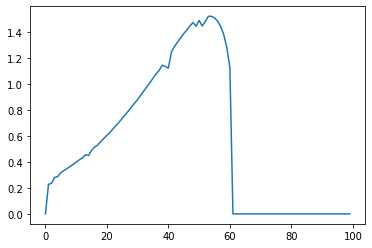

In [94]:
plt.plot(olg.c[0,60,:100])

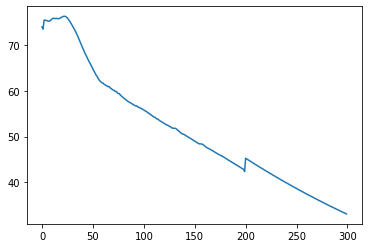

In [278]:
plt.plot(olg.Labor[:300])

In [313]:
k=3
olg.household(0,259-k,248-k,248-k)


(19.135572375153398, 0.40698405787412806, 112.9854178242148)

In [265]:
for i in range(olg.T):
    olg.update_guess(i)
    olg.update_household(i)
    print(i)

KeyboardInterrupt: 

In [260]:
olg.update_guess(1)
olg.update_household(1)

In [177]:
for i in range(2, olg.T):
    olg.update_guess(i)

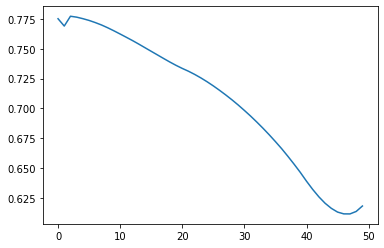

In [261]:
plt.plot(olg.l[0,50,:50])

In [262]:
olg.evaluate_initial_state()

74.08700174172273
74.08700174172273
74.08700174172273
74.08700174172273


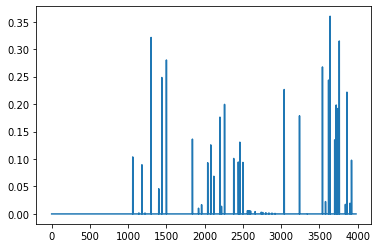

In [131]:
plt.plot([i['fun']  for key, item in olg.history.items()for i in item])

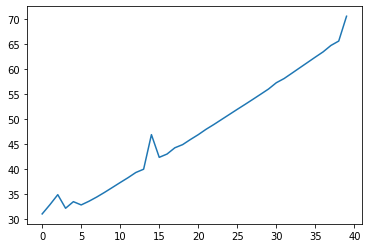

In [51]:
plt.plot(olg.Gov_Income[:40])

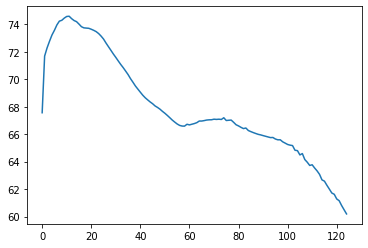

In [105]:
plt.plot(olg.Labor[0:125])

In [7]:
from olg import *
olg = OLG_model(G=60,T=250,N=N,epsilon=epsilon, rho=rho,
                sigma = sigma,Pi=Pi,r = r,price_M =price_M,
                price_E=price_E, tau_I=tau_I,tau_II=tau_II,tau_Ins=tau_Ins,
                tau_pi=tau_pi, tau_VA=tau_VA, tau_rho=tau_rho, beta = 0.99,
                theta =1,
                phi =0.23, # цель 38 миллионов в стеди стейт или 65% в начальном положении
                psi = 163.
                , omega=0.269
                , alpha = 0.35, delta=0.0608,
                A=A,initial=initial, Oil=Oil,eta =0.25,steady_max_iter=5000,max_iter=5000,
                steady_guess=steady_guess)

In [4]:
from olg import *
olg = OLG_model(T=200)

In [7]:
olg.steady

array([  2.3167618 ,   0.72691265,   0.87036366,  11.62847021,
         1.        ,   1.        , 447.5913557 ,  48.56260336,
       510.48451492])

# Рисунки

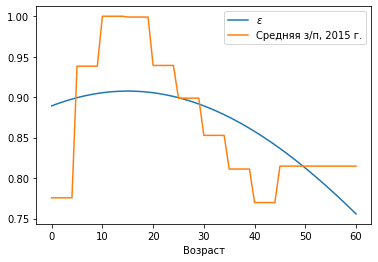

In [466]:
plt.plot(np.exp(model.predict()), label=r"$\varepsilon$")
plt.plot(np.exp(df_wage_ext['wage']), label = "Средняя з/п, 2015 г.")
plt.xlabel('Возраст')
plt.legend()
plt.savefig('plots/epsilon.pdf')

In [11]:
with_migration = {name:np.array(pyreadr.read_r(f"{name}.Rda")[f"{name}"]) 
                 for name in ["N_female", "N_male"]}

In [12]:
fact_pop =[None,146.267288, 146.544710, 146.804372, 146.880432, 146.780720,146.748590, 146.171015, 145.557576]

In [13]:
rosstat_forecast = pd.read_csv("rosstat/demo_forecast.csv")

In [23]:
rosstat_forecast

,year,low,medium,high
0,2021,146412.8,146650.1,146888.2
1,2022,145988.6,146536.9,147078.8
2,2023,145420.7,146372.4,147281.9
3,2024,144763.7,146135.9,147444.9
4,2025,144032.2,145858.3,147582.4
5,2026,143244.0,145539.5,147713.8
6,2027,142412.3,145210.9,147846.2
7,2028,141555.7,144882.9,147990.5
8,2029,140679.5,144569.1,148159.7
9,2030,139787.5,144274.0,148361.0


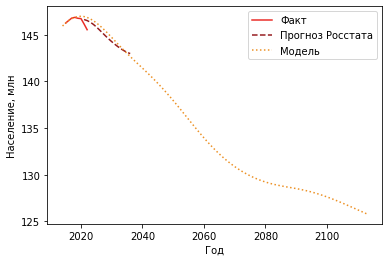

In [42]:
plt.plot(range(2014,2023),fact_pop, label = 'Факт', color=ranepa_colors[1])
plt.plot(range(2021,2037),rosstat_forecast["medium"]/1000, label = 'Прогноз Росстата', color=ranepa_colors[0],linestyle="dashed")
plt.plot(range(2014,2114),(with_migration["N_female"].sum(axis=1)+with_migration["N_male"].sum(axis=1))[:100],
         label = "Модель",linestyle="dotted", color=ranepa_colors[2])

plt.ylabel('Население, млн')
plt.xlabel('Год')
plt.legend()
plt.savefig('plots/population.pdf')

In [46]:
from olg import *

In [50]:
retirement = np.array([[val*rho_reform[0,g-21,t] if 21<=111-g+t<=80 else 0 for t, val in enumerate(row[:-1])] 
                for g, row in enumerate(with_migration["N_female"].transpose())
])+np.array([[val if 111-g+t>=60 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_male"].transpose())
])
children = np.array([[val if 111-g+t<=14 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_female"].transpose())
])+np.array([[val if 111-g+t<=14 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_male"].transpose())
])
other = np.array([[val if 14<111-g+t and 111-g+t<55 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_female"].transpose())
])+np.array([[val if 14<111-g+t and 111-g+t<60  else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_male"].transpose())
])

IndexError: index 669 is out of bounds for axis 1 with size 669

In [4]:
retirement_reform = np.array([[val if 111-g+t>=55 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_female"].transpose())
])+np.array([[val if 111-g+t>=60 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_male"].transpose())
])

NameError: name 'with_migration' is not defined

In [14]:
N_total = with_migration["N_female"].transpose().sum(axis=0)+with_migration["N_male"].transpose().sum(axis=0)

In [15]:
from olg import *

In [16]:
rho_all_ages_wo_ref = np.array([[1 if 111-g+t>=55 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_female"].transpose())
]),np.array([[1 if 111-g+t>=60 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_male"].transpose())
])
rho_all_ages_ref = np.array([pd.read_csv("rho_female_test.csv", sep=',',header=None).to_numpy(),
                    pd.read_csv("rho_male_test.csv", sep=',',header=None).to_numpy()])

In [17]:
# rho_all_ages_ref = np.array([[1 if 111-g+t>=60 else 0 for t, val in enumerate(row)] 
#                 for g, row in enumerate(with_migration["N_female"].transpose())
# ]),np.array([[1 if 111-g+t>=65 else 0 for t, val in enumerate(row)] 
#                 for g, row in enumerate(with_migration["N_male"].transpose())
# ])

In [18]:
rho_all_ages_ref[0][:,:5],rho_all_ages_ref[1][:,:5] = rho_all_ages_wo_ref[0][:,:5],rho_all_ages_wo_ref[1][:,:5]

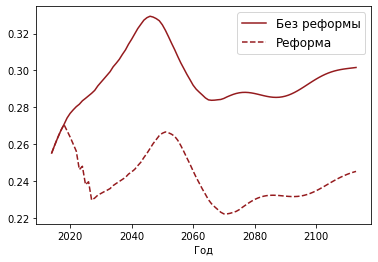

In [19]:
retirement = with_migration["N_female"].transpose()*rho_all_ages_wo_ref[0]+\
with_migration["N_male"].transpose()*rho_all_ages_wo_ref[1]
plt.plot(range(2014,2114),(retirement.sum(axis=0)/N_total)[:100], label=r"Без реформы", color = ranepa_colors[0])
retirement_reform =(with_migration["N_female"].transpose()*rho_all_ages_ref[0])+\
(with_migration["N_male"].transpose()*rho_all_ages_ref[1])
plt.plot(range(2014,2114),(retirement_reform.sum(axis=0)/N_total)[:100], linestyle="dashed",color=ranepa_colors[0],label=r"Реформа")
plt.legend()
# plt.ylabel('Доля пенсионеров')
plt.xlabel('Год')
# plt.title("Доля пенсионеров")
plt.savefig('plots/dependecy_ratio_reform.pdf')

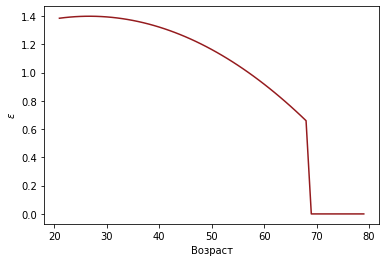

In [32]:
plt.plot(range(21,80),epsilon[0][159,100:159],color=ranepa_colors[0])
plt.xlabel('Возраст')
plt.ylabel(r'$\varepsilon$')
plt.savefig('plots/epsilon.pdf')

In [7]:
olg.update_a_initial()
olg.create_guess()

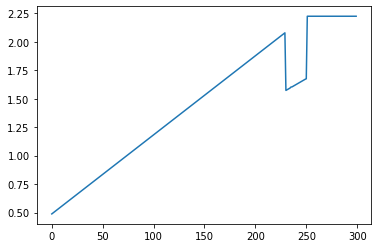

In [13]:
plt.plot(olg.k[0,:300])

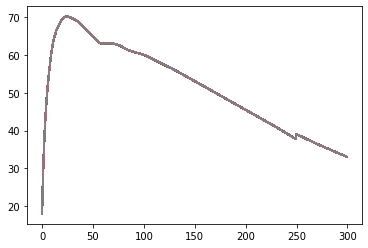

In [14]:
for i in reversed(range(1, 229)):
    olg.update_guess(i)

In [65]:
olg.lmbda_to_price[1,249]

1.348661539231219

In [68]:
t=249
0.5*np.array([olg.i[0,t+1],olg.k[0,t+2],olg.L_share[0,t+1],\
            olg.lmbda_to_price[0,t+1], olg.i[1,t+1],olg.k[1,t+2],\
            olg.lmbda_to_price[1,t+1],\
            olg.w[t+1], olg.price_N[t+1], olg.price[t+1]])+\
            0.5*np.array([olg.i[0,t],olg.k[0,t+1],olg.L_share[0,t],\
            olg.lmbda_to_price[0,t], olg.i[1,t],olg.k[1,t+1],\
            olg.lmbda_to_price[1,t],\
            olg.w[t], olg.price_N[t], olg.price[t]])

array([ 0.06861176,  3.16948031,  0.60866257,  1.26994532,  0.06861121,
        1.82370699,  1.28349722, 23.5044066 ,  0.97563833,  0.97005048])

In [82]:
olg.w[148]

8.582537239123752

In [83]:
olg.history[148]

[     fun: 1.3167890216468667e-17
     info: {'x': array([0.06937677, 3.20596418, 0.44381836, 1.44662514, 0.06937788,
        1.84428038, 1.52187372, 6.96987998, 0.81918051, 0.7612096 ]), 'g': array([], dtype=float64), 'obj_val': 1.3167890216468667e-17, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
     nfev: 10
      nit: 9
     njev: 11
   status: 0
  success: True
        x: array([0.06937677, 3.20596418, 0.44381836, 1.44662514, 0.06937788,
        1.84428038, 1.52187372, 6.96987998, 0.81918051, 0.7612096 ])]

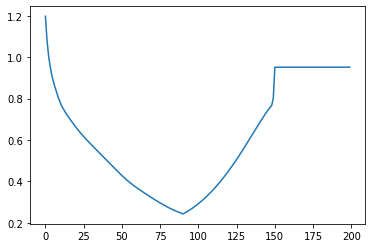

In [78]:
plt.plot(olg.Consumption[:200]/olg.Labor[:200]/olg.A[0,:200])

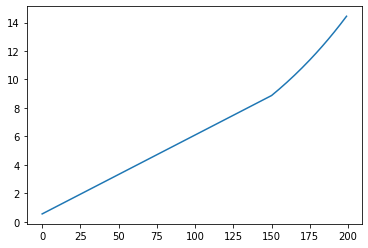

In [32]:
plt.plot(olg.w[:200])

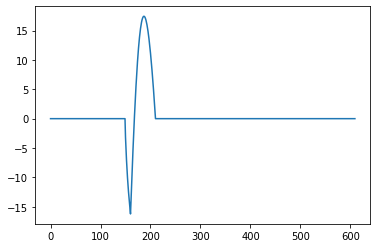

In [46]:
plt.plot(olg.a[0,:,150])

In [45]:
olg.household(0,150,100)

(1.9566893576706055, 0.7650662741534084, 11.769610295671846)

In [13]:
olg.create_guess()

In [3]:
olg.create_guess()

In [5]:
olg.update_guess()

TypeError: update_guess() missing 1 required positional argument: 't'

13.97038559398257
13.97038559398257
13.97038559398257
13.97038559398257


In [42]:
t=0
(1-olg.alpha)*1 *(olg.k[1, t]/(1-olg.L_share[0,t])*olg.A[0,t]/olg.A[1,t])**0.25* olg.A[1, t] 

0.5739835384774816

In [45]:
olg.Labor[0]

13.97038559398257

In [36]:
olg.k[1, t]

0.12039529431235176

In [38]:
(olg.k[1, t]/(1-olg.L_share[0,t]))**olg.alpha

0.8401958128048662

In [37]:
(olg.k[1, t]/(1-olg.L_share[0,t])*olg.A[0,t]/olg.A[1,t])**olg.alpha

0.8401958128048663

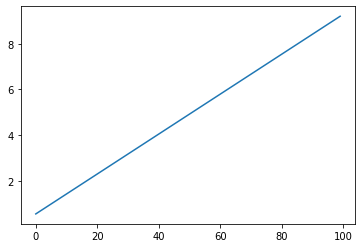

In [22]:
plt.plot(olg.w[0:100])

In [11]:
olg.Consumption[250:350]

array([ 556.42002429,  560.10190598,  563.808151  ,  567.53892059,
        571.29437701,  575.07468364,  578.88000489,  582.7105063 ,
        586.56635448,  590.44771716,  594.35476317,  598.28766245,
        602.24658609,  606.23170628,  610.24319637,  614.28123086,
        618.34598538,  622.43763676,  626.55636296,  630.70234314,
        634.87575766,  639.07678803,  643.305617  ,  647.56242852,
        651.84740774,  656.16074106,  660.5026161 ,  664.87322172,
        669.27274803,  673.7013864 ,  678.15932948,  682.64677116,
        687.16390666,  691.71093245,  696.28804632,  700.89544737,
        705.53333601,  710.20191398,  714.90138435,  719.63195154,
        724.39382133,  729.18720083,  734.01229857,  738.86932441,
        743.75848963,  748.6800069 ,  753.6340903 ,  758.62095531,
        763.64081886,  768.69389931,  773.78041644,  778.90059152,
        784.05464726,  789.24280785,  794.46529898,  799.7223478 ,
        805.01418298,  810.34103472,  815.70313472,  821.10071

In [13]:
810/805

1.0062111801242235

In [64]:
35.92413367/demography['N'][:,:,250].sum()# цель 0.65 

0.616574344522428

In [6]:
olg.evaluate_initial_state()

441.5391345933429
441.5391345933429
441.5391345933429
441.5391345933429


In [11]:
"k_N_steady", "L_N_share",
"k_E_steady", "w_steady",
"price_steady", "price_N_steady"

('price_steady', 'price_N_steady')

In [12]:
demography=np.load('demography.npy', allow_pickle=True).item()

0.8150489457014909

In [48]:
olg.create_guess()

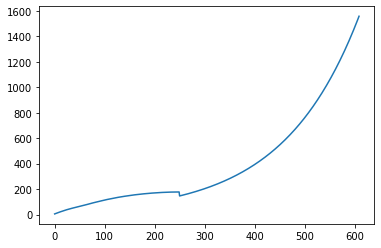

In [56]:
plt.plot(olg.w*olg.Labor*olg.tau_rho/(1+olg.tau_rho + olg.tau_Ins))

In [35]:
olg.VA_sum# + self.I_sum[t]+self.II_sum[t]+self.Ins_sum[t]+self.Rho_sum[t]+self.Pi_sum[t]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [23]:
olg.steady_state()
olg.steady_path[-1]

(     fun: 9.860698309180621e-17
     info: {'x': array([ 4.14947849,  0.82643216,  0.87147639, 22.42212501,  1.00000004,
         1.00000005]), 'g': array([], dtype=float64), 'obj_val': 9.860698309180621e-17, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
     nfev: 2
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([ 4.14947849,  0.82643216,  0.87147639, 22.42212501,  1.00000004,
         1.00000005]),
 array([ 4.14937873e+00,  8.26414768e-01,  8.71565246e-01,  2.24221394e+01,
         1.00000130e+00,  1.00000177e+00,  1.24402971e+03,  3.84706709e+01,
        -4.60350340e+04]))

In [22]:
for i in range(10):
    olg.steady_state()
    print(olg.steady_path[-1][0]['success'])

True
True
True
True
True
True
True
True
True
True


In [18]:
(2.61244168e+00/4.96977115e-01)**0.35*4.96977115e-01

0.888351756370893

In [27]:
(3.59554431e+02/2.38258337e+01/19+olg.i_steady*(2.61244168e+00+2.59784231e+00))*0.8

0.9174244994958803

In [12]:
olg.Gov[250]/olg.A[0,250]

369.55613492546206

In [94]:
olg.steady_path

[]

In [25]:
olg.create_guess()

4.514081065421861
4.49981883316465
4.485601662408552
4.471429410781825
4.457301936362546
4.443219097677199
4.429180753699247
4.415186763847732
4.401236987985858
4.3873312864195935
4.373469519896267
4.359651549603178
4.345877237166203
4.332146444648413
4.318459034548689
4.304814869800348
4.291213813769765
4.277655730255017
4.264140483484501
4.2506679381155905
4.237237959233273
4.223850412348797
4.210505163398333
4.197202078741618
4.183941025160635
4.170721869858261
4.15754448045695
4.144408724997401
4.131314471937237
4.118261590149692
4.1052499489222924
4.0922794179555515
4.079349867361662
4.0664611676632
4.053613189791823
4.04080580508698
4.028038885294622
4.015312302565922
4.002625929455987
3.9899796389225886
3.9773733043248867
3.9648067994221634
3.9522799983725583
3.939792775731808
3.927345006451989
3.9149365658802675
3.9025673297576517
3.890237174217743
3.8779459757855
3.865693611376
3.8534799582932084
3.841304894228746
3.829168297260669
3.8170700458522444
3.805010018850735
3.792988

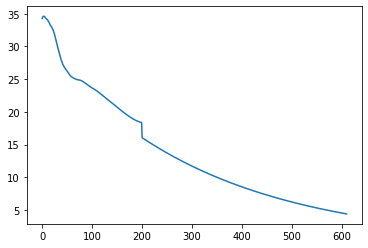

In [26]:
plt.plot(olg.Labor)

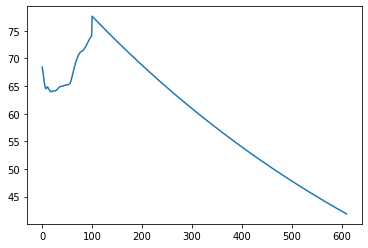

In [11]:
plt.plot(olg.Consumption)

In [52]:
tol = 10e-5
niter = 30

Ищем steady state

In [641]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for _ in tqdm(range(niter),
                  desc = 'Steady state',
                      token=os.getenv('comp_bot_token'),
                      chat_id=os.getenv('chat_id')):
        olg.steady_state()
        if (len(olg.steady_path)>1) and \
            (max(abs(olg.steady_path[-1][1] - olg.steady_path[-2][1]))<tol):
            
                break
olg.update_a_initial()
olg.create_guess()

Steady state:   0%|          | 0/30 [00:00<?, ?it/s]

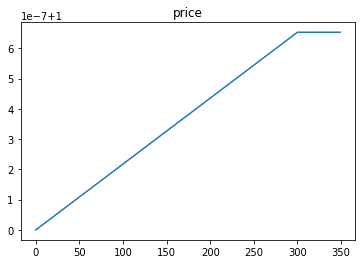

In [642]:
bot = TelegramBot(os.getenv('comp_bot_token'),
                      os.getenv('chat_id'))

plt.plot(olg.price[0:350])
plt.title("price")

bot.send_plot(plt)

# This method delete the generetad image
bot.clean_tmp_dir()

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

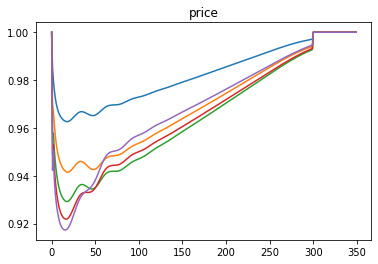

In [420]:
for i in range(5):
    for t in tqdm(reversed(range(1,olg.T)),
                      desc = f'path to steady {i}',
                      total=olg.T-1,
                          token=os.getenv('comp_bot_token'),
                          chat_id=os.getenv('chat_id')):
        olg.update_guess(t)
    plt.plot(olg.price[:(olg.T+50)])
    plt.title("price")

    bot.send_plot(plt)

    bot.clean_tmp_dir()

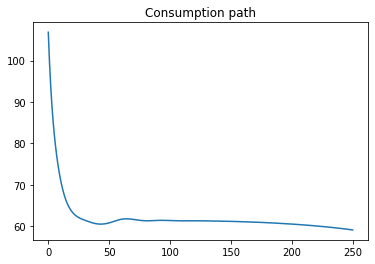

In [643]:
bot = TelegramBot(os.getenv('comp_bot_token'),
                      os.getenv('chat_id'))

plt.plot(olg.Consumption[:251])
plt.title("Consumption path")

bot.send_plot(plt)

# This method delete the generetad image
bot.clean_tmp_dir()

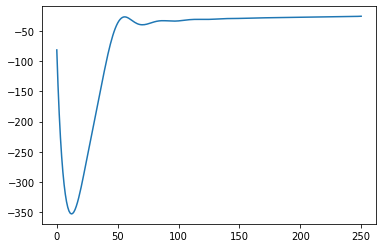

In [627]:
plt.plot(olg.Assets[:251])

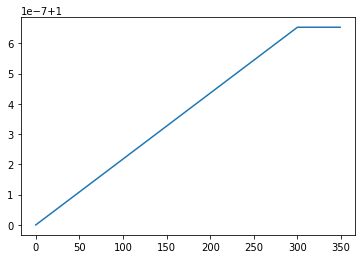

In [625]:
plt.plot(olg.price[:350])

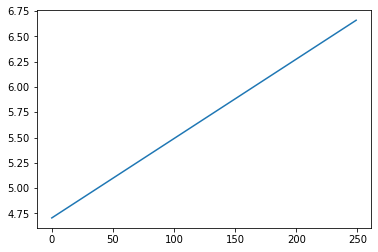

In [626]:
plt.plot(olg.k[0,:250])

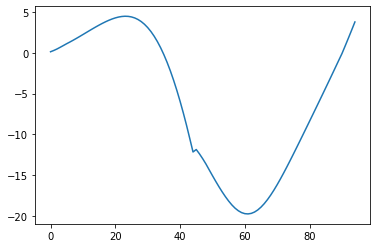

In [498]:
# plt.plot(olg.Pi[0,(45+olg.G-1):45:-1,45])
# plt.plot(olg.c[0,(45+olg.G-1):45:-1,45])
plt.plot(olg.a[0,(45+olg.G-1):45:-1,45])

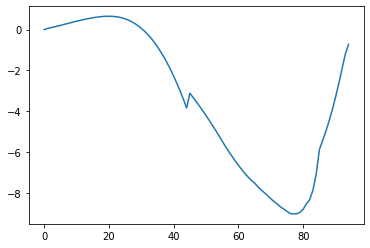

In [515]:
t=0
plt.plot(olg.a[0,(t+olg.G-1):t:-1,t])

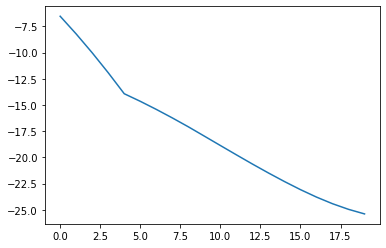

In [494]:
plt.plot(olg.a[0,250,155:251][40:60])
# plt.plot(olg.Pi[0,250,155:251])

In [ ]:
olg.c[0,90:110,45]

In [201]:
high_deficit = np.where(olg.Deficit_ratio[:(olg.T+1)]>0.2)[0]
if len(high_deficit) > 0:
    olg.sigma =np.concatenate((olg.sigma[:high_deficit[0]],
                           np.array([olg.sigma[high_deficit[0]]*0.9 
                                     for _ in range(high_deficit[0],max_time)])))
    if olg.T-olg.G + 1 < high_deficit[0]:
        olg.T = high_deficit[0] + olg.G - 1

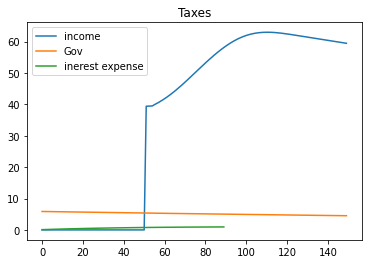

In [537]:
# plt.plot(olg.Gov_Income[200:250])
# Ins_sum  II_sum I_sum VA_sum Pi_sum
plt.plot(olg.Gov_Income[100:250], label = "income")
# plt.plot(olg.Ins_sum[160:250], label = "insurance")
# plt.plot(olg.II_sum[160:250], label = "investment income")
# plt.plot(olg.I_sum[160:250], label = "income")
# plt.plot(olg.VA_sum[160:250], label = "value-added")
# plt.plot(olg.Pi_sum[160:250], label = "profit")
plt.title("Taxes")
# plt.plot(olg.Gov_Outcome[0:250], label = "outcome")
plt.plot(olg.Gov[100:250], label = "Gov")
plt.plot(olg.Debt[160:250]*olg.r[160:250]/olg.Gov_Outcome[160:250], label = "inerest expense")
plt.legend()

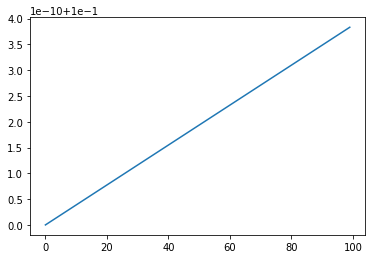

In [210]:
plt.plot(olg.price[:100])

In [214]:
olg.price[100]

0.10000000038709678

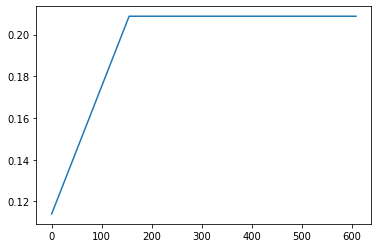

In [221]:
plt.plot(olg.w)

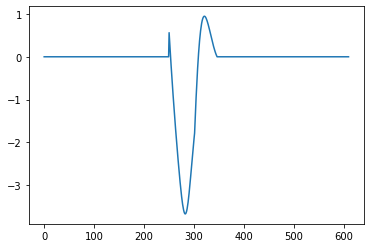

In [215]:
plt.plot(olg.a[0,:,250])

In [25]:
olg.create_guess()

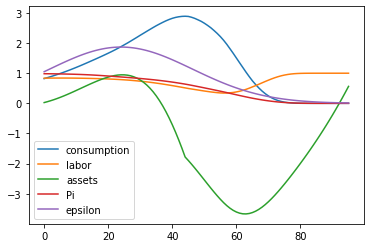

In [216]:
plt.plot(olg.c[0,345:249:-1,250], label = "consumption")
plt.plot(olg.l[0,345:249:-1,250], label = "labor")
plt.plot(olg.a[0,345:249:-1,250], label = "assets")
plt.plot(olg.Pi[0,345:249:-1,250], label = "Pi")
plt.plot(olg.epsilon[0,345:249:-1,250], label ="epsilon")
plt.legend()

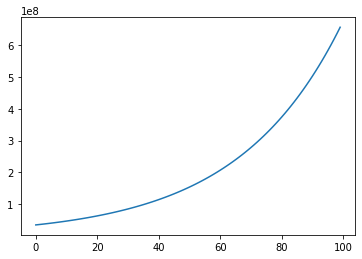

In [179]:
plt.plot(olg.Deficit[150:250])

Text(0.5, 1.0, 'wage adjustment')

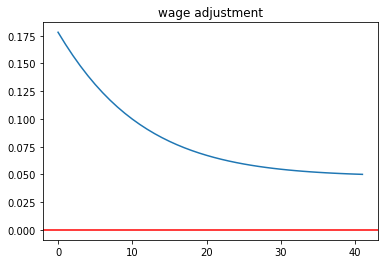

In [173]:
plt.plot([item[1][6] for i, item in enumerate(olg.steady_path)])
# plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)])
plt.axhline(y=0, color='r', linestyle='-')
plt.title("wage adjustment")

Text(0.5, 1.0, 'Labor')

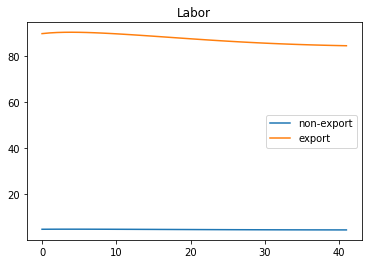

In [174]:
plt.plot([item[1][1]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "non-export")
plt.plot([(1-item[1][1])*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "export")
plt.legend()
plt.title("Labor")

Text(0.5, 1.0, 'Capital')

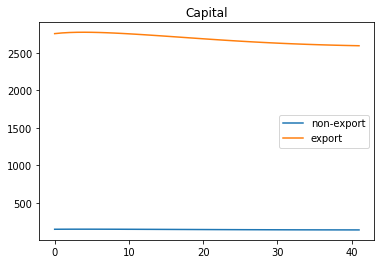

In [175]:
plt.plot([item[1][0]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "non-export")
plt.plot([item[1][2]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "export")
plt.legend()
plt.title("Capital")

Text(0.5, 1.0, 'non-export labor share adjustment')

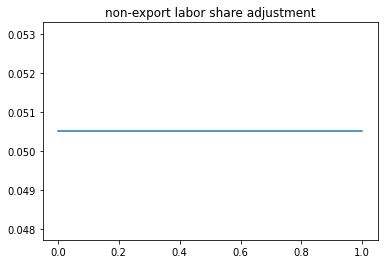

In [217]:
# plt.plot([item[1][0] for i, item in enumerate(olg.steady_path)])
plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)])
plt.title("non-export labor share adjustment")

Text(0.5, 1.0, 'cons adjustment')

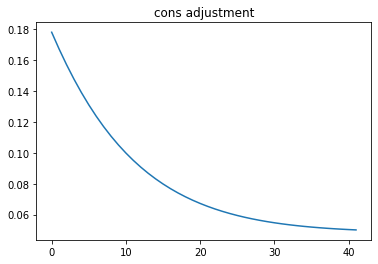

In [177]:
plt.plot([item[1][-3] for i, item in enumerate(olg.steady_path)])
plt.title("cons adjustment")

Text(0.5, 1.0, 'price adjustment')

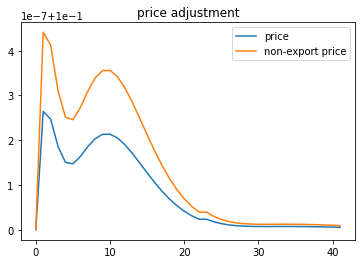

In [178]:
plt.plot([item[1][4] for i, item in enumerate(olg.steady_path)], label ="price")
plt.plot([item[1][5] for i, item in enumerate(olg.steady_path)], label ="non-export price")
plt.legend()
plt.title("price adjustment")

Text(0.5, 1.0, 'Target function')

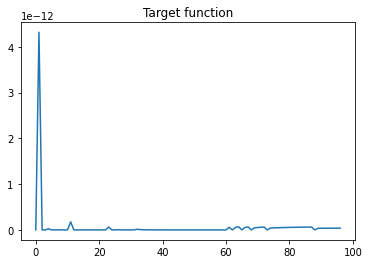

In [163]:
import matplotlib.pyplot as plt
plt.plot([item[0]["fun"] for i, item in enumerate(olg.steady_path)])
plt.title("Target function")

Text(0.5, 1.0, 'k')

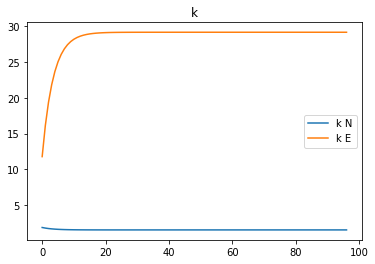

In [164]:
plt.plot([item[1][0] for i, item in enumerate(olg.steady_path)], label ="k N")
plt.plot([item[1][2] for i, item in enumerate(olg.steady_path)], label ="k E")
plt.legend()
plt.title("k")

Text(0.5, 1.0, 'k non-export adjustment')

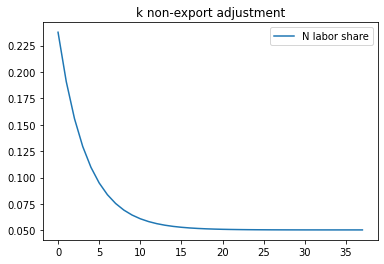

In [152]:
plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)], label ="N labor share")
plt.legend()
plt.title("labor share")

In [279]:
olg.steady_path[-4]
# единственный выход это потребление тоже менять с eta

(     fun: 497133.5107400712
     info: {'x': array([ 6.50888420e+00,  7.89066419e+02,  3.67245615e+04, -8.85181784e-03,
         2.52521567e+01,  3.05824304e+03,  5.72445545e+04,  3.73356679e-02,
         1.81871797e-01,  2.67263830e-08,  2.11897026e-02]), 'g': array([], dtype=float64), 'obj_val': 497133.5107400712, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': -3, 'status_msg': b'An unrecoverable error occurred while Ipopt tried to compute the search direction.'}
  message: b'An unrecoverable error occurred while Ipopt tried to compute the search direction.'
     nfev: 629
      nit: 21
     njev: 25
   status: -3
  success: False
        x: array([ 6.50888420e+00,  7.89066419e+02,  3.67245615e+04, -8.85181784e-03,
         2.52521567e+01,  3.05824304e+03,  5.72445545e+04,  3.73356679e-02,
         1.81871797e-01,  2.67263830e-08,  2.11897026e-02]),
 array

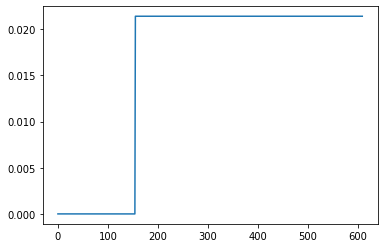

In [38]:
import matplotlib.pyplot as plt
plt.plot(olg.w)

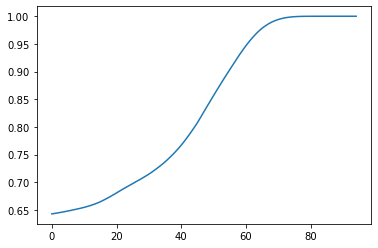

In [606]:
# plt.plot(olg.c[0][345-30,(250-30):(345-30)]) # труд у дрпугих неправильно рассчитывается?
# plt.plot(olg.l[0][345-30,(250-30):(345-30)])


In [43]:
olg.w[99]

1.3201810425347083e-05

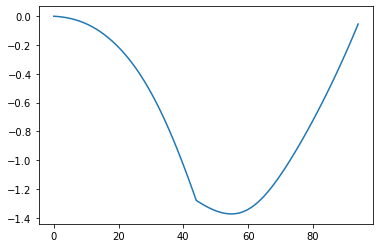

In [25]:
# plt.plot(olg.l[0][260,165:260], label= "labor")
# plt.plot(olg.c[0][260,165:260], label = "consumption")
plt.plot(olg.a[0][260,165:260], label = "assets")
# plt.plot((olg.c[0][260,165:260]**olg.phi * (1-olg.l[0][260,165:260])**(1-olg.phi))**(1-olg.theta)/(1-olg.theta), label = "utility")
plt.show()

Text(0.5, 1.0, 'Wage path')

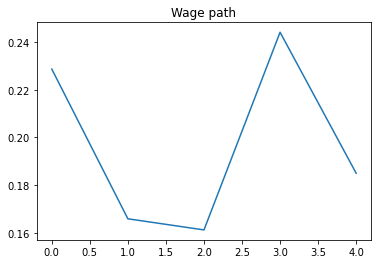

In [614]:
plt.plot([item[0]["info"]["x"][8] for i, item in enumerate(olg.steady_path)if i != 1] [0:])
plt.title("Wage path")

Text(0.5, 1.0, 'Price N path')

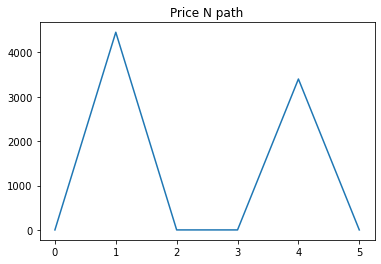

In [615]:
plt.plot([item[0]["info"]["x"][10] for item in olg.steady_path][0:])
plt.title("Price N path")

In [ ]:
import matplotlib.pyplot as plt
# plt.plot((((olg.c[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:150])
# plt.plot((((olg.a[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:150])
plt.plot((((olg.l[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:250])
# plt.plot(olg.I[0,:100]/olg.N[0].sum(axis=0)[:100])
# plt.plot((olg.l[0,:250]*olg.N[0,:250]).sum(axis=0)/(olg.N[0,:250].sum(axis=0)))
plt.show()

In [ ]:
plt.plot(olg.I[0,1:100]/olg.I[0,0:99])

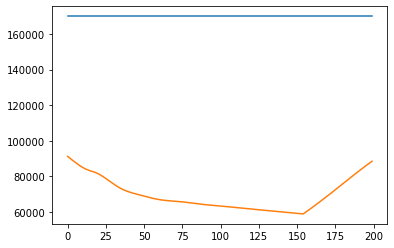

In [616]:
plt.plot(olg.L[0][:200]+olg.L[1][:200])
plt.plot(((olg.l[:,:610,:]*olg.N[:,:610,:]*olg.epsilon[:,:610,:]).sum(axis=0).sum(axis=0))[:200])

In [331]:
olg.L[0][:200]+olg.L[1][:200]

array([170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 1700

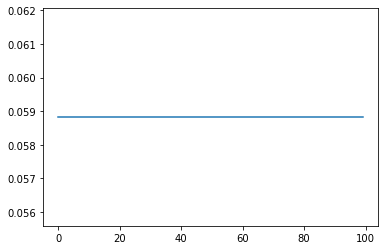

In [332]:
plt.plot((olg.K[0]/olg.L[0])[:100])

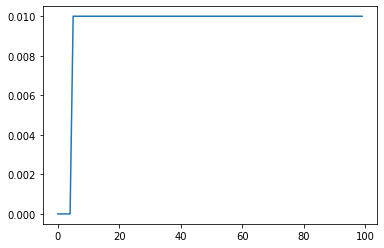

In [44]:
plt.plot(olg.a[0][100][:100])

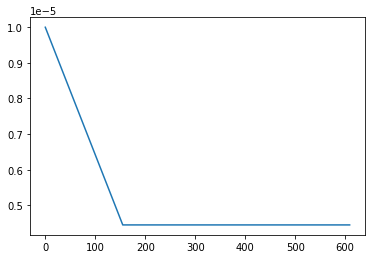

In [45]:
plt.plot(olg.price_N)

In [54]:
olg.w[120]

1.2925927310610548e-05

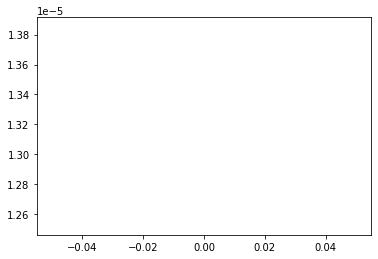

In [49]:
plt.plot(olg.w[100])